Team: **Skynet**

Team members:
* Tobias Gutenkunst
* Fabian Seipel
* Steffen Rummel
* Ludwig Winkler
* Marvin Buß
--------------------------------

# 5. Independent Component Analysis

In [1]:
# imports
import os
from scipy.io.wavfile import write
from IPython.core.display import HTML, display
from __future__ import division
from matplotlib import style
style.use("ggplot")


import scipy as sp
import numpy as np
import pylab as plt
#import pandas as pd
import warnings

warnings.filterwarnings('ignore')
sp.random.seed(1)

In [2]:
# play functions in iPython notebook
try:
    from IPython.display import Audio
    def wavPlayer(data, rate):
        display(Audio(data, rate=rate))
except ImportError:
    pass

# 5.1 Initialization

**(a)** Load the sound files. Each of the $N = 2$ sources is sampled at at 8192 Hz and contains $p = 18000$ samples.

In [3]:
s1 = np.fromfile('sound1.dat', dtype=float, sep='\n')
s2 = sp.fromfile('sound2.dat', dtype=float, sep='\n')

s = sp.stack((s1, s2))

**(b)** Create a random (& invertible) $N×N$ mixing matrix $A$ and mix the sources: $x^{(α)} = As^{(α)}$

In [4]:
A = sp.random.randint(1, high=11, size=4)
A = A.reshape((2,2))
A = A + sp.eye(2)

# compute true W
W_true = sp.linalg.inv(A)

print('A:')
print(A)
print('W_true:')
print(W_true)
print(sp.linalg.det(W_true))

x = sp.dot(A, s)
sp.io.wavfile.write('mixed1' + '.wav', 8192, x[0,:])

A:
[[  7.   9.]
 [ 10.   7.]]
W_true:
[[-0.17073171  0.2195122 ]
 [ 0.24390244 -0.17073171]]
-0.024390243902439032


**(c)** Remove the temporal structure by permuting the columns of the $N×p$ matrix $X$ randomly.

In [5]:
idx = sp.random.permutation(18000)
x_shuffled = x[: , idx]

**(d)** Calculate the correlations between the sources and the mixtures:

$$\rho_{s_i,x_j} = \frac{cov(s_{i},x_j)}{\sigma_{s_i} \sigma_{x_j}} $$

Correlation
[[ 0.61447647  0.81943208]
 [ 0.78977943  0.57430557]]


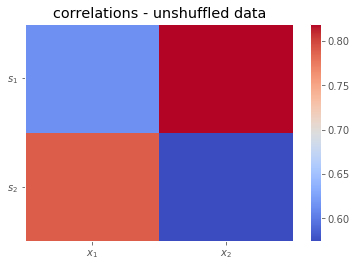

In [6]:
# matrix with correlations
'''
__|x1|x2
s1|
s2|
'''

def compute_correlation(x, s):
        # alternatively use sp.corrcoef
        # calculate standard deviations
        s_std = sp.std(s, axis=1)
        x_std = sp.std(x, axis=1)

        corr = sp.zeros((2,2))
        for i in range(2):  # s
                for j in range(2):  # x
                        cov = sp.cov(s[i,:], x[j,:])[0][1]
                        corr[i, j] = cov / (s_std[i] * x_std[j])
        return corr

def plot_correlation(corr, title, xticks1='$x_1$', xticks2='$x_2$'):
        print('Correlation')
        print(corr)
        
        plt.figure()
        plt.pcolor(np.flipud(corr), cmap=plt.cm.coolwarm)
        plt.xticks([0.5, 1.5], [xticks1, xticks2])
        plt.yticks([0.5, 1.5], ['$s_2$', '$s_1$'])
        plt.colorbar()
        plt.title(title)
        plt.show()

corr = compute_correlation(x, s)
plot_correlation(corr, 'correlations - unshuffled data')

Correlation
[[-0.00081656 -0.00404893]
 [ 0.00200207  0.00521384]]


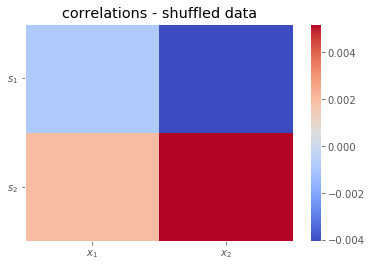

In [178]:
corr = compute_correlation(x_shuffled, s)
plot_correlation(corr, 'correlations - shuffled data')

**(e)** Center the data to zero mean.

In [7]:
x_mean = sp.mean(x_shuffled, axis=1).reshape((x.shape[0], 1))
print('Mean of audio signals:')
print(x_mean)

# center shuffled data
x_shuffled_centered = x_shuffled - x_mean

# center unshuffled data
x_centered = x - x_mean

Mean of audio signals:
[[ 0.12238597]
 [ 0.10073907]]


**(f)** Initialize the unmixing matrix $W$ with random values.

In [8]:
W = sp.random.randint(1, high=2, size=4)
W = W.reshape((2,2)) * 0.1
W = W + sp.eye(2) * 0.1

# 5.2 Optimization
Implement a matrix version of the ICA online learning algorithm. For $f^ˆ$ use the logistic function (see lecture notes). This should reduce your code for this part to a few lines with one loop (over
the samples). Implement two variants of this learning algorithm:

**(a)** Compute the update matrix $∆W$ using the “regular” gradient.

<img src ="img.png">

$$ 
e^{\alpha} = \ln \, \text{| det} \mathbf{W} \, \text{|} + 
\displaystyle\sum_{l=1}^{N} \ln \hat{f}_l' \, 
\left( \displaystyle\sum_{k=1}^{N} w_{lk} \, {x_{k}}^{(\alpha)}  \right) 
$$

$$
\frac{\partial e^{(\alpha)}}{\partial w_{ij}} =
(\mathbf{W^{-1}})_{ji} +
\frac
{\hat{f}_i'' \left( \displaystyle\sum_{k=1}^{N} w_{lk} \, {x_{k}}^{(\alpha)}  \right) }
{\hat{f}_i' \left( \displaystyle\sum_{k=1}^{N} w_{lk} \, {x_{k}}^{(\alpha)}  \right) }
\cdot {x_j}^{(\alpha)}
$$

$$
\hat{f}_{(y)} = \frac{1}{1 + \exp{(-y)}} \, \Rightarrow \,
\frac {\hat{f}_i''} {\hat{f}_i' } = 1 - 2 \, \hat{f}_i 
$$

In [9]:
def ICA_regular_gradient(W, x):
    gradient = sp.concatenate((sp.dot(W, x), sp.dot(W, x)), axis=1)
    gradient = sp.special.expit(gradient) * 2
    gradient = sp.ones((gradient.shape)) - gradient
    gradient = gradient * x.flatten()
    gradient = sp.linalg.inv(W).T + gradient
    return gradient

**(b)** Compute the update matrix $∆W$ using the natural gradient as described in the lecture notes.

$$
\Delta W = \epsilon \ \frac{\partial e}{\partial W} \ W^T W
$$

In [15]:
def ICA_natural_gradient(W, x):
    gradient = sp.concatenate((sp.dot(W, x), sp.dot(W, x)), axis=1)
    gradient = sp.special.expit(gradient) * 2
    gradient = sp.ones((gradient.shape)) - gradient
    gradient = gradient * x.flatten()
    #print (x.shape)
    normalization = sp.dot(W.T, W)
    #print (gradient.shape)
    #print (normalization.shape)
    gradient = sp.dot(gradient, normalization)
    return gradient

**(c)** Choose a suitable learning rate $η$ and apply both versions to the data to unmix the sources.

In [18]:
def ICA(W, x, n=0.0085, method='regular'):
    vals = []
    t = 1
    
    for _ in range(2):
            for i in range(x.shape[1]):
                # adaptive learning rate !? --> bad results and not wanted
                rate = n #/ t
                
                # select random datapoint
                #idx = sp.random.randint(0, high=18000, size=1)
                #datapoint = x[:, idx].reshape((2,1))
                
                # choose next datapoint
                datapoint = x[:, i].reshape((2,1))
                
                gradient = 0
                if method == 'regular':
                    gradient = ICA_regular_gradient(W, datapoint)
                    W = W + rate * gradient
                elif method == 'natural':
                    gradient = ICA_natural_gradient(W, datapoint)
                    W = W + rate * gradient
                
                if (t % 1000) == 0:
                    val = sp.sum((rate * gradient) ** 2)
                    vals.append(val)
                
                t = t + 1
    return W, vals

def unmix_sources(W, x):
    return sp.dot(W, x)


# for unshuffled data
print (W.shape)
print (x_centered.shape)
W_regular, vals_regular = ICA(sp.copy(W), x_centered)
s_regular = unmix_sources(W_regular, x_centered)
W_natural, vals_natural = ICA(sp.copy(W), x_centered, method='natural')
s_natural = unmix_sources(W_natural, x_centered)

# print('W_natural')
# print(W_natural)
# print('W_true')
# print(W_true)

'''
# for shuffled data
W_regular_shuffled, vals_regular_shuffled = ICA(sp.copy(W), x_shuffled_centered)
s_regular_shuffled = unmix_sources(W_regular_shuffled, x_shuffled_centered)
'''

W_natural_shuffled, vals_natural_shuffled = ICA(sp.copy(W), x_shuffled_centered, method='natural')
s_natural_shuffled = unmix_sources(W_natural_shuffled, x)

print('W_natural (W learned from unshuffled data:')
print(W_natural)

print('W_natural_shuffled (W learned from shuffled data:')
print(W_natural_shuffled)

(2, 2)
(2, 18000)
W_natural (W learned from unshuffled data:
[[ 0.01044336 -0.00564302]
 [-0.01299021  0.01451953]]
W_natural_shuffled (W learned from shuffled data:
[[ 0.01393209 -0.00983158]
 [-0.00917761  0.01210527]]


# 5.3 Results

**(a)** Plot & Play (i) the original sounds (e.g. use scipy.io.wavfile to save playable files), (ii) the mixed sources (before and after the data permutation), and the recovered signals (estimated sources) $sˆ = Wx$ using the unpermuted data.

In [184]:
def plot_and_play_data(data, title, label1, label2):
    sp.io.wavfile.write(label1 + '.wav', 8192, data[0, :])
    sp.io.wavfile.write(label2 + '.wav', 8192, data[1, :])
    print(label1 + ':')
    wavPlayer(data[0, :], 8192)
    print(label2 + ':')
    wavPlayer(data[1, :], 8192)
    
    # plot data
    x_axis = sp.arange(data.shape[1])
    
    plt.figure()
    plt.plot(x_axis, data[1,:], 'b-', label=label2, alpha=0.5)
    plt.plot(x_axis, data[0,:], 'r-', label=label1, alpha=0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.grid(True)
    plt.xlabel('time')
    plt.ylabel('sound')
    plt.title(title)
    plt.show()

sound 1:


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAAAAAAAAAAD6/wIA+v/1/wUA6v8GAP//8P8WAO3/AQAUAPT/CgA4AOH/TQAFAPP/ggCd/2cA3P/Q/7AAgf90AB8AN/80ASv/SQCnAFz+VAIJ/uwAswCY/SYDnP2uACEB7/y0A2/9mwBEAl77kAXV+1oBmQLK+QwIG/nqA+wAfvk+CRv2Vwce/qH7bwmw82ELPfoO/6oH+PNiDXX1VQU6AsT2pA0w8hMKpfzw+3EKtPJ0DRz3EgPkBF31fw1c8h8JqP4e+rAMEfC8DeL3wACoBofyQg8Z83IJAABh+U8MnfGJDOr5CQGcBMH1pAy385QJqfvm/lYGjff8CfD1KQgo/G0CQQD9+JULSfNJDNT5Vv/tBNn72wdA9GMMo/TdBCcHQvMeC2j4vwTD+QsIrfmK/I4Sf+hIESH+CfRhEHf3xP2DAxwBcvqfBEwFvPAMDtoBHPNOElD2efqPDsb7SfcNDJ756fW/Fffy0/l4EU/xAAAJEZvvff5QEZHxigGXDs7s8QEcERrxav4nEmzrlwJ5G6XfqAevFaXfUBNpC6XfhhInEDrhGxQ8CRDeMh0NCOfanRsDAxDeriZS+jrhriZe9mPkQijZ77zobCuM5w/v1yk64cT2bCtS2WX8bCsp1q4F1yl3zf4M1ykkx3QYMh37w4QjGxROyhklkg53za4mogl3zWwrrgVr0QAt0wEA05Uugv93zbI1I/l3zS4/5esp1i4/+OUQ3tw4+OU64dw4+OXO4tw4Y+TO4tw4+OXO4tw4zuKM59w4zuIb6yowzuIP75Uu+OV67UIo5et67dcpG+uM5wAt5eu86GwrG+uM5wAtsOxj5AAtD+/O4iow2e864WwrXval364mMP2+164m0wFS2YQj0AJ83J0baQvn2oYSGxRS2bwRCBqU1F0PnRsp1sgNMh0p1gcKMh3n2mgDxh464er+WyA64Yj5hCPO4lL68CE64fn1QiiM5w/vbCv45eXriTLO4obpiTLO4rzolS686GPkiTKw7HzciTKj8HzciTIC877XKjCF/mvRbCuuBXfNQijRCk7KWyC8EWvRdBh6FpTUXQ+dG5TUPAnwISnWzQNCKFLZaPtsK77XvfiVLufal/RCKM7iL/VCKGPk2e+uJhvro/CEI9nv5esZJdnvjOeEI83zY+SuJiP559psKxz7vtfXKYX+vteEI10PANN6FnQYKdY8CfAhfNy9+NcpzuKG6QAteu2l35UuWPgp1kIoqAcA050bhhIA01ATMh0p1kkFWyAQ3iP5bCul327xKjDO4kTuAC0b62PkbCsp9+faQihDB3fNhCOvFSTHxh5bIPvDGxTXKXfNt/oqMBDeG+uyNYbpUtmJMtACd83wIeUUJMcyHa4m+8MyBIkyKdYC89w4EN4Q3gU8l/TWzwAtoglOysYe8CEkx3gGsjVr0aPw3DjO4nzc3Di3+iTHbCsIGvvD5RQqMPvDm/tYQinWfNyBRaPw+8MuP2kLLLSVLkIoVrdpCy4/+8Mb6/1O59pOyv1OX/4stNw4hCOwqjIdWEIDsY73eVhOytbPeVjZ7wOxqkgyHTSh8CGqSLCqXva0ZtLATsq0Zg/vh6fUS1sgTJkZJdRLh6c48vVhTsokx8xevfhdpIFFAC1MmXQYo1tdpIznWXNOyla3tGaeAvqSqkgFPPqSUBP1YbCqUtlZc77XsKr1YScQ+pLcOKpI+pKhAbRmVrdOygZteu00oVBV1ymnjIQjo1sLnobpWXMkxwOxBm1rAkyZWEIFPEyZqAfMXqi9Tsq0ZjjyNKH9TgAt+pLGHsxeNKHO4gZtANMstMxekg5MmYkyqkhdpI73zF5OyiTHzF7H/V2kBTyyNV2kDQgnUvvDUtlQVV72A7HcOGwrA7HXCNRLTsqU1HlYzfMstAU8GSUDsZIOWEIkx87i1EsC86i9sjXwIVa3yA0uP07KEN4nUjjyf7qJMlsgLLTIDdRL0sAQ3idSD+/SwNw4xh4stP4Mqkj7w+faJ1JE7qi93DjGHiy0/gyBRU7KfNyqSO35qL0qMK4mVreeAv1Od82+16pIjvfSwJUuQih/umL9gUV83GvRLj8TBqi9GSWyNai9D++qSDrh1s8FPDwJ0sAIGpUud82w7Nw4o/AA02wrhhJOymkLlS5S2YznsjWO99bPGSV6FnfNeAZsK2PkzuIALZsDa9EIGvAhANMp97I15evn2kIo1wiU1CcQhCM64XrtQigw/XzcRBd6FlLZAPzXKXrtpd+uJqgHlNQnEDIdpd8C8xklI/kQ3ggaGxQQ3rEA8CGw7Pjlxh5pC+fabArGHs7io/CEI2X8EN56FhsUzuLH/Vsgo/CM5zIdPAk64d0GnRtR6gLzxh5S+oznvBG8EYbpiPmvFYj5RO4nEGkLjOee/kQXlPVu8V0P0AKj8JgE/gzz95f0bAoTBi/1nv4zDJj8l/TXCK4FXvbR/kMH/ADz957+aQvR/l72DQgTBpf0BP/+DGL9zfNJBQ0IiPmb+xMGoQGO9zb/aQu4/s3zDQjdBsT2Hf8TBoL/APyb/5sDewFo+/wA1wj6/fP3QwebA+35FgEGAsf9hf4WATkC0wFS+v383Qab//38zQO4/p7+OQLq/mIB4wBY+GUAcggz/Gj7Qwct/gD8mAS4/soAZQAc+2gD0wG3+gMDSQUc++MAMgQc+3sBaAMc+5v/5AT6/cf9eAbn/+355ATTAYj5EwZIAfn1ZQTkBCn30ALXCMT2hf48CYj5Lf4NCO35aPuoB5j8HPsNCC3+UvrdBoL/7fllBKEB7fnTAeQEHPtf/hMG+v1l/BMGm/8c+zIEoQG3+qEBrgUc+1/+DQjO+xz7PAme/r343QahAfP3awJJBVj4nv6oB877zvt4Brj+UvrkBHsBt/oGAs0Dm/sE/zIEX/79/GgDewHO+/wA0AL6/Z7+BgIyAF/+AABIAc7/uP5P/+MA4wDR/hYBBgKe/l/+awJ+AMr8FgE5AjD9zv85Al/+6v6hAUsAT/9LADIAgv/n/xkANv+1/0sA4wBlAAT/sQC1//r9ewGXAC3+lwAWAQT/ygBiAQT/zv/KAE//5/9+AOr+gv8yAGn/tf+XAIL/T/+XAAAAm/+XAEsAT/8ZALEAm/8AAEgBm/9p/2IBAAC4/rEAAAAt/jIALwG4/rX/oQE2/0//YgEyAIX+ZQBLAIX+tf/jAJv/gv8WAef/Hf/KAJcA0f4yABYBNv/O/0gBzv8d/5cAMgAE/+f/SwAd/0//lwAyAE//fgCxADb/SwD8AGn/5/+xALX/BP8AADIAT//n//wA5/+C/+MAZQBP/xkAfgBp/7X/sQC1/wT/SwAyADb/SwDKAAT/gv/8AJv/Nv/KABkA6v5+AJcABP/O/34AT/+C//wAGQBP/34AZQAd/xkAsQBP/0//sQDn/x3/fgCXAAT/zv+xAGn/af+xAJv/6v5+ADIAHf8yALEAgv8AAOMAAACb/zIAAABp/wAASwCb/87/MgDO/5v/GQAAAJv/AAAZALX/AAAyAAAAAAAZAOf/AAAZAM7/tf/O/7X/5/8AAM7/zv8AAOf/5/8AAOf/zv/n/+f/5//n/7X/zv/n/wAAzv/O/wAA5//n/+f/zv8AAAAA5//n/+f/5/8ZAAAAzv8ZAAAAzv8AADIAAAAAADIAAADn/wAAGQDO/+f/AADO/+f/GQDO/7X/AADn/87/5//n/87/tf8AAOf/tf8AABkAzv+1/xkA5/+b/+f/AAC1/5v/AADn/7X/5/8AALX/tf8ZAOf/zv8ZABkA5/8ZAAAAzv/n/xkAzv/O/xkAAADO/+f/AADO/+f/GQDO/7X/AADn/5v/tf8ZAAAAzv8AABkAzv/n/xkA5//n

sound 2:


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAAAAAP//4v/t/wUAJwAXANz/zf92//7+uv5B/gP+KP/Z/4P/+v4AACUBBQIPA6kCUwKRASMBAACk/t39Hf/a/4j/Ev57/fP95P0a/1L+bf/IANEB3QHYAFr/4gDiA6cEEQMzAT4AwP5AAL//EAEyBacGVAd1B1kCAABMALP/RPuh+Yf5EvpU/az/+f4LAZEEPAi1CE0G/wJpA08HpQSRATL/NgGgAboDxgNnA7UBlP9B/m/8rfWu+DwDGAVUAon/AAAAAOQEfQd2BqQHlwUfA48BDvjw9mX+VgRgBOADHwH0+s35L/mP+BD5/fWk93j5UvZ88bT4jAXKCIsMBgy6BY0CFgc6BZ0C/AFOA2MFXgEy+SD3D/cX9GH16/PV8yf1S/+2AHoBowavBrsGQAgEA/f8TQKvBBgDPP+j/Z/99QMmDDoMsQ72BFb+W/k666bhbear8KX2Kf/YAD/+Jwa9EJISShVJFgEScw+DBav4S/CW+MoCogSJBwAAPvpH+Wz2NfkN/wAA+wHrAwj9BfgA/fwEEAgpEjgOGAb8BBQH/AQABBQHDAn9DAkK/AQE//j9/Pz4/fT22+zf69vs2+z/8wT77Pj4/QQDBAP8BP0MGhYWFyEUCAIA/Pj9CAL8APwE/AD09uLq9uX55OroA/ME/xQHFAf8BBAIGAb8BAUL/QwABAAABPvM8M/vCAIBDCEUJRMBDBgGAADw9/v0+/TM8Nft0+7b7Nft7Pj8BCkSFhcpEjEQIRQxEDQPOA4YBgQDAAQABPz8BPv8/Pj9/AD4/ez49/X09uj5BAMABAAE+P0E/wD8BP8QCDQPJRP9DPwA+P38BPwE/AQ0DwULBP/o+QPz6uji6gPz7Pjw9+j5BPsE/wD8CAIQCAwJCQoMCQAAA/PI8QT7GAYUBwAE/AAE+8jxA/P09uz4+/QD88zw0+4D8wAAEAgFCxAI/AQUBxQH/AQEAwQDCAL8BAkK/AQEAwULNA8tEQwJBP/09s/v6ujf68jx9Pb79Pv07Pjo+QAEGhZiJGoiDhkxEAwJ/AQABBQHGAbs+Pv0A/Pi6tvs9PYEAwAAAAQJCgkKFAcYBhQHEAgEAxgGAATw9/v0/AA0DyUTKRItEQULAAT4/fz8APz39QPzz+/u5+7n//P8/BgGAAQBDDQPOA4BDAEMFAf8BAAABP/8/Pj9CAIQCP0MFAcEAwAA+P3w99ft2+zI8czw//P39cjx+/T8BB4VGhY4DgkKEAgEAwT/FAcMCQgCAPwE//f1zPD39fj9/Pzw9+j57Pj79APz9Pbs+AT7+P0ABAgCAPwEA/0MMRA4DjgOCQoIAgT79Pb09vT29/Xs+PT2zPD09gT/FAcUBwgCCAIIAgQD/AAE/wT/AAAE/wgCBAMMCSUTChoaFikS/QwUB/z8+/Tf69/r5unm6dft//Pw9xAIJRN5HgcbFhcaFiUTBQv8BAAEAAAA/AD87Pj39ej5GAb9DBQHGAYABAQDAAAE//z8BPvo+fz8BP/4/fz8/AQMCQkKBQsFCwkKGAYE/+z48Pf39QPzyPHM8M/vA/P8/Pj9/PwAAAAEFAcUBxgGAAAAAPz8APwA/AT7/AAQCAULFAcEA/wE/AT8AAT7+/TI8c/v//MD8//z8Pf4/RQHCQoMCQUL/QwMCQAE/AAAAAT/BP8AAPz8/PwABBAIFAcEA/z8BPvo+ez4yPHX7cjx9Pb8/AAE/AQFCzQPNA8BDAkKDAkUB/wEAADw9/f17PgE+wT7/Pz4/fj9BAMYBgAEFAf8BAQD/AAE/wT7+P0E//j9BAMFCykSGhYOGR4VJRMpEv0M/AD39eLq8ub55O7n4urX7ff1+P38BAwJAQwpEhYXLREFCwT/6Pn79Pv0A/P79PD3BP8EAwAEBAMYBhgG/AD8/P/zz+/P78zwyPHw9/z8AAQJCgEMCQoJCv0MOA4FC/wE/PwA/AD8BPsA/Pj9BPvo+ej5/Pz4/fwA/AT8BAT/APwAAPwAAAQABBQH/AQUBwkKBQs4DjEQLREBDAQDAPz/88zwz+/I8fT2+P38AAgCBAMEAwwJMRAtETgOBAPo+ez4APwA/Pj9/AQUBwwJCQoQCBQHGAb8AAT7//PP79PuyPH/8/f17PgAAPwECQr9DAULFAcQCPwEAPwD8wPzzPD79PD3BPv8AAgCBP/8AAgCCAIABAQDBPvM8NPu0+709vz8BAP8BBQHDAkJCgkKAQwxEDEQAQz8BAT79/UD89Puz+/w9wT//AAIAvwEEAj9DDEQGhYxEBQHBP/w9+z49Pbo+QAA/AQYBv0M/Qz9DC0RBQsE//D39/X79PD38Pfs+AT7APwA/PwAFAcYBgwJAQwMCQT/BP8A/Pz8CAL8BAgCAAQIAvz8+P0E/wgCAAQEA/D3//PM8Mzw6Pn8BBgGBQs4DgkKBQv9DAUL/Qw0DxAI+P3s+Pf1yPED88jx9/Xs+Oj5BPv4/QT/AAAABAAE/AAAAPz8APzo+ej5BPsE/wQDFAcFC/0MOA79DPwEBPvM8Nft0+7T7vf19PYE/wAAAAAYBgUL/QwpEikSFAf8/PD3//P09vz8APwEAxAI/AQIAgQDBAMABBAICAIE+8jxzPDT7sjx9Pb4/fwEEAgMCf0MAQwJCjgOOA4EAwT76Pn09vT28Pf79Oz4+P0AABgGDAkJCv0MCQoABPj97PgE+wT7/PwA/Pz8BP/8APwEDAk0DyUTIRT9DAgC6Pns+PD37Pjs+AD8+P38/AT7+P0AAAQDEAj8BAT/8Pf/8/f16Pno+fz8FAcBDAULAQwQCAQDBAMIAuz4z+/P7wPz//P39QD8/AQUBwwJ/QwBDAwJDAkJCgAEAPzo+fz8BP8E/wAACAL8BPwE/AQYBgAEGAYUBwAEAPwD8/f17PgE+wAAGAYQCAwJAQz9DAwJEAgMCQULCAL09sjx//P79PD3/PwAAAT/CAIEA/wAAAQUB/wEBAP8/Pf17PgE++z47Pj8AAgC/AQMCQwJ/AQYBgAEBP/09s/vyPHw9+j5BPsAAAQDBAMYBgwJFAcYBhgGAAT8/PT2//ME+wT/BP8IAggC+P34/QT/BP/8/Pj9/PwE+/v0A/Pw9wT77Pj8/AAEBAMABBQH/AQEAwQD/AQYBggC/PwE/wQD/AAAABgGBAMIAvwEAAT8AAT/APwA/AT//Pz4/QQDGAb8BAEMCQoMCQEMOA79DAkK/AT4/ez4yPHI8fD36Pnw9/z8GAb8BBQHEAgYBhQHEAgABAQD/Pz39fD3AAD8AAQDCQoQCBAIDAn8BAAEAAQAAAT76Pn39fv06PkE+/z8AAQUBxgGEAgYBhgG/AQIAgAA/AD8/Oj5+P34/ej5APz8AAgCCAIAAPz8AAD8/PT2+/TI8dPuA/Po+QT7/Pz8APz8+P38BPwEGAb8BAT/APzo+fv06PkAAPwA/AAUBxgGAAQABAT/+P0IAgAABPvs+PD38PcE+/wAAAQBDDgO/Qw0DwkKGAYYBhQHAPzw9//zzPD39fz8/AAEAwwJEAgBDAEMGAYEAwAA8Pf09gT7+P38APwEBQsBDDEQ/Qz9DAkKCAIE/wT/6PnP78/vz+8D8/z8FAcQCAUL/QwBDP0MBQsMCQwJAAT39dPu1+3M8Pv0BPsEAxgGCQoFCwEMDAkEA/wA/ADo+ff1+/QD8wPz7PgE/wgC/AQUBxQH/AQAAPwAAAT4/fv0//P39fT2APwAAAT/BAMYBhQHCQoQCAAABP/4/f/z//Po+fz8/PwUBwwJDAkFCzQPOA4QCAgC+P0A/PD3z+8D8/f1BPv8ABAIDAkQCBQHBAMAAPz8+P0AAAT/9/X09gT7AAD8BAEMBQsQCAwJEAgEAwT78PcE+/f1zPDM

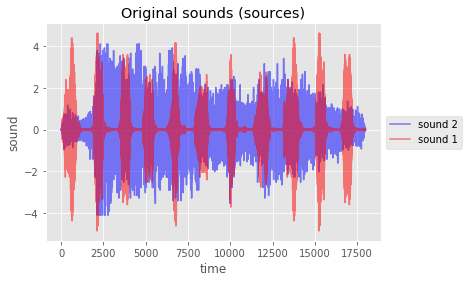

In [185]:
# (i) Plot & Play the original sources
plot_and_play_data(s, 'Original sounds (sources)', 'sound 1', 'sound 2')

observation 1:


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAAAAAAAA7f/x/wQAFAAHAO3/1P+u/1//LP/4/rn+fP/0/6z/ZP8fAKMAbQHoAZ4BuwHAAO8A7P8N/xL/K/8qAMj/W/4g/0H+2/7R/wX++ABe/6cBjgEn/2QBMP/LAocDJgDcArD+k/9zATP91QPXAOQEBgYUAQwGEfxrAlcAWvlSAVj2gwBF/U39vgSg+VMJ0QHbBEcI//rACYT+6wU+Ajz6iQgh+Q8IbADL/wQHJviXBrj4W/tB/vD72wqq+eoEPP+l/EUKjfvXCxoA5QO8BUj5xwMG82QEsALw/m0JffgGBK/4X/wG/tv1AQHQ82oBhvdh9hj/n/4kCwgCHAxbAfcCiQQ+/zoI+/kPCdL/dwCY/iL48f7r8XsACPI8+1z9S/jIBpb80gaVAMIIgQHl/7QIBfTDDNkAs/jhB6j5LQGICTYI7wW2Bf4BLPMk+0DuzOjxAKz0VPzUCIH82P5AEd0Hbwc4GrkDDQZiDRPzRPYfBWD4AgKMDsT3UP0oBB3v5vwsCYD3UgDJDGvyiPzQDaLwXQmgF1v2zA6ZCe7xqA2yC9XyFBFSDdzyvxP7A5Tp4g11AAjnMwpJ8JTiMwoR8yjtlBKH9Zn0pBok9WP+kSXB/DQHCBp056/8CBq+6FQGexiQ3VT6uwfQzqX/mwgm3aYY2w915CkaFwxD5uUciw2n5cUYJgAA3KMPTQLE7Q0nlQuc6mkiFvws3jcdtO213soYgebG4C4Vw+yJ8bErdf+a+nkqufxh+dwp9/kg804i0/GI9JEeQew28jga9e8T9TAW7urT7zETZ/bq91ka0vJx8TEX7PO69zIi8v8a+kkaufNX88McbfnF+E4iLfar6rgQM+x04AQOAvoJ5EoS9P1T6cgR3QK98FwVugxy8JEKawMf4QYHoRKe6z4LXRAK5Q3/mwiG4lUB0wnJ4ob46QZl5mL/dRdG9U4BWhe88yUBcxZQ8Cb8Ohgk9Y783RsF81z7QSb++cr4OBy96bHoRAxA5m/nOBcn7unkcRh28zjuhyojD13+ASswCQnr3Ru4BY/nvxrIAYraaAoI/Y/ZVwixDjvnPgv5FXPtqAkjF4XsKwfWGLbt3P/GEzTiePwAJLT2vgSdIS32T/y1FWHuTvTZDwjsNO1YBd7nF+1LE5D6iPS0G3YCEPmBHYUDOe/dGzb9bOgAFub9S+pDGdAQt+qxDvMN3+ZFABsI398M83IO6Of27NwQm+6i8KknVAny8DAdXQky6CQP9A7w60cMLQ6F58z8CQls5tP65xaL6OnzFxeE6NXtEBSx7yjtgxdw/RjsfRQDBjnrTB4vFWHoxhe4E6va3AVDEpDdxPYXFwjnqOoGGZHyU+44Id0CbuSeFMoNLOALEHQVwt3IARceAOoz/k4syPxW+n8tigHp6M4Xq/7k1BQFqgXe0XD4MRdt4Dz8Tiw7An38vy6uCm7rmh/xET3g6wv/GEjbG/mhH1vkhO+0L6D7ieGGJmEIvtT3GRkVdNO7Ai0iJt3S8jEr7e365kgz5gWS26gmChi4zkQM2SC4zCLzqSnx133abCrr9K7RlienEGbMvxfYLRvTgvqXOhba494cOD/zI85CMEoZzMkIF1kuntDA+Ms0itrA1gwsa/SswzYgrRQmxFYSfzpV0eL420n65gbZMzt+ATHB2Cg+Iu+/JgldOlTUU+6tQyrnPcwcNNME/bguFaQgMbwQ/xI9o9ky6J9H3P5c0eQ2eh2VwloXRzQew/bsaz153NnPVDwfACbEuCcFJuTHwQgsOQbc+uH7OQz1qch0LGoYrMNjGFZBntfg/klLMvL/3yI+7Agxv74P7Rn5ukTs/ygc1ljZ0jTSAVXRrinkKQjaPQ+yNSbdKObXKa3z48qbGcYTVNLqBr0tPeMC60A2p/nf0s0aIQvnyOT+CR2R2nrtvS3P/pjh2iSUGZjerRDgKnXkxepjLKn1QtVZGjMRp9EVBHsnFtpi63ovbfkM39QfEw++1AUI7ys94Dnv9TFG+l/gRCdfGsfeDhIXLz3jQukEIhzzHtCqEnUQSdUaAlIuCuXn6hAvNwWa5mMj1hiS1B/6LCVC6SvkIifaB8PfYhuiI4reHfoRKlrrFd01GKH6JNNpB1sUyN779Icjdf1h7pof9A5e5pkJGBji4QDqNRVa9IbfExJvDW7kFANiGYLxm/AnHO0DVuJtBbcIr9tZ9cMcZ/bt7Vsbpwpz7W8PtBt7+Hj/aB57AaboDgfFBErfr/PfEtP0J+5TF3UHOuxEEbAaPfufAo0Zefuk53YK3AXd6GUAcxbC+DP5mxmPDnv1xgzyEFnqBfFvDfL4pOdvCGEI3uxB/BIToPvU9UMWtQwN9E4DJA8m8bj20RLa/0/zmQxgC0/xDfvDC5L9XfgVC4MBnOrK9dkDR/bH+ooMbwgMANcIPQ50A1EA/w3kDNT+9P2SAtf3rvD//G76SfTw+l0Aev0m+pr+ggbNAf38NAV3A5/39fyiA7v68/VnAnYGsgBSBIQLvgk7A6MCawPY9cnt8/lG+YP04/nbArj/uP2NA+MI5QiiCNELbgn6/Gn2tPxz/Kr6JP4GA7oDPgLhASMD6QI+/0cDLQWw/Hj1v/ig9Gb2qfsf/uEDgQU9AUYIQgwMBDEG9AzTAKH62P6p+dj6O/ti9o/9yf/9/H8FnwhtA44InQix/5f/j/0f+rD86wBe/N38FAONAKD/Zgh3CiwI8Q/ICIr7vP5n/vX1OP2oAED45v1mAzj5s/2YBGj+YAJ1B3L9N/go/b34/PgjANr96wDyCcIH+QMKBqgEFf9UABX/0PTp82v7Vvj+9uv/BQRfAYkGSgumBK0EMwrSA7H/ygJv+/35TgNRAGj7owIbBrn+TQIlCBUAYQEUCL8BSPq++qH6mfgR/isCRAFvBAEIggZUBo0H2AU2A2QH3QI9+Wb2uPlJ+RP6Iv67AEf/hgB5AR4B/AK2A7UDBgNY/dr4//wx/cj5PPzgAaj/+gLgBq0EeAK1BKYC//6Q+hT26Pbz+kj8dvzV/wkCYAIABAsFyASbA58CUwN4/lr55viI/dT+2P8MArIAof4y///+Vv9q/h/+2v0G/db4yPdY+6H8OPt4/noCpAHRAo4EsgLtAUMC3QLGA/0B6P0O/6gCnABF/ywE3gE3ADQDKAPh/zn/dP4S/f/+7P7b/gYBAARCA5gGDAYdBjYHiAirCCkGlQIy//T7g/ZN96D7xvvk+t3+qgOVArkEHAU2A1QEKgX5AXkBeP7l+Zz6SAABAWsBYwaPBagEjQV8A08C6gEAAAb91Pu6+bz5K/yh/KT+tAL+A9UDRwVwA5sDfAMXAXD/xwA//sb76f4y/6n7Pf0sAQgBzgBzADD+Yv9q/rv6nPgT96P1j/fx+3r9MP43AGr++P6VAiUDLASyAv/+6/0r/Kr4gvxWAAsAfwDIBHADJALfAir/H/6KARwAZ/y6+2b7ufrp/B4BegI2B+0IDAgWCTgG8gONA0YEov3k+lb4ovbI+ej9nADtAXAF/wSNB3AHxgPtAfL/Aftz+sz8k/5/AOsCxQZwB+wJ8AcMCCkGMwFk/1b/Hfzp9en16fXl9/f9RgTxBNQG8AdTBwwIxQaNBY0FXgLI+Vv1sfSF9h752/ztAcYDGwbiBnAHfgXeAbkAnAA6/OX5LPnl9/T3rPtH/zMBFwNGBFQEJQPk/3AAegKw/g/5gfi6+Uj6Wv0AAFb/swHGA3EEGwbUBA4AVv+E/oH4kPgO/Oj9Iv5UBHAFjQXUBkEJpQgNBTMBof6U/Q/76fUC+Mj5zPyNAA0FfgXiBHEE3gHk/xP+vv7k/1b/1/lI+r78AAAIAzYHqQYNBZsF4gTeAfj85Prb/Nf5hfaF

observation 2:


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAAAAAAAA8v/y/wQADQABAPT/1v/F/4b/Wv9B/wL/nf///7z/jv8sAHAAMAFzATQBfgFtANoA5P83/4v/Mf9KAOH/ef7G/2H+Pf8YAOn9kwHQ/pUBbgF9/jAChf5cAhMDAv+AAxX+5v/qATX86AQi/zAEfgWT/noHifo+A5cAn/hWBCD1CQNB/WH8/ga79ikLTP9UAwcJ3/c1DBL7ZwZ/Ak74YQvR9bsJHP9g/hQJQ/XXCUn3mf1xABb5FQ1I9gMH8P5W+1kM4vbqDSf9NwO9Bg72XQiH8bsGCALO/JMLIPWRB0X4of0qAKH0UwVZ8ocEBvhT+JkB6PsIDOj9Ggyk/x4DhgPl/GgK2/ZJC6P9HQC2AI34CAIb8dYEVfEn/pUAkvUkCa363wYx/ocJ2/6s/kgNdO7kD/j/KfbfCx/4FQB6CJwGfAL9BWsDyvBlAT/zzOlSB+/zOvvvC9T7+vtlEaQD+wGuGx3+WAJuEOzwpPgGClD0+ABBEZD0hv5pCEzsXP4dDTL0rP85EE3uUP5eFLLo2QmyGQbtKRJhC67pBBGtDu7qLBRoDc/peRnrBabheBRvAd3grRUQ8qPerRW+8sjnlhw/8vru0yP27qr4hCtv8h0CXSN53zH8XSNO39YGniG202YA8xRGxo4IDBH5z3cfQBPJ1y4hZw5K2tEjuQ3U2WkiKgL10xMcZgL34VoulQiU3Wktj/os1Ogs5+q3148pUuMi3IwkDejz6ZI1MfZh8aY0jvN08DA0CfK563kuvuqA7qUrh+YH7jclVOmf8Zkhq+YU7Qwde/Ey8wgjfe4p7Mohm+9Y8Yopa/i28iAkvu907AAm6fT+71UrvfLB5FIcjO123JAYdPpR3MwbHf/j4EUaLwOi5yAavw3Y5q4O2Amv2rcLfBfp4A0OWBaB3EEEDBGa2qAE+BGD3JP7VhCG4ST/bB3H7Kf+fB4v7NH+Ox0H6Xj52yD27kf3vyTJ7Dz1LS/q8G7ylieg5PnlGBog5HTjziOI67DeuyT48LvlaDLBBjrw6jFqBlTfvyRgBkXbwyJBBUjQjRMoBBzSIw86E5fdDQ6WGkviowrAHSniywZSITTkPf6hHu7atfoLLJPref/1JwjuTvn0HrToU/HzGVrpPezdEOvncer8Gw/2gO7GIXb9yfBHJC8A6+W/JCD8ot++H+D9DOHtH0MSqN86E2AT5N2KA2IS4dqV8wgaPeN86f8cKOyy6NAuSgSC5Zwk2QnA3WwV/xGU4EIQQhVi3n3/gxJn4Jz5/yCU4pnx2iKz49zrbB8g7MjndSHf+o7jBx4rBwvevCPaF5vZFx2YGhnOsQvqHLbTHPfaIt3gUehQJrrtq+ReKy8D6NjYG/kRZ9OsFjEecNDdAgApQuDz+Qg2UPF37xQ4DP0m3UAieAIDzPQOiRCVyJ787SRO15v3CDYm94bw4TcrBurbkyf4FlDSjxBLJI/OM/nfL/zbtuYrPSX3S9PyM3UK6cN0JH4eFMQvBqgw+c997i898OSw2U1D3wMTycMxAR/uu9ETzDCzvDjzcz9Szj7SBkDJ8XPALDgjF8C2Nh7oPEC/XvhkUYTMktODTz3wWbrfP84e7rHQHm4+ObyL9UtLSNBHzIlDn/RLsXQx4h+prbIWU02fu8rxgGGw2UrI2lETAiOpIDmQLzCo5A2CTyzAq+TTXK7eDrrGSnsJ76KMJOwyXKXh/0RTwMid2oddc/iBulBIZiXop3wen0iXrnzpGFib0BG//FT3AKmt/TVsMn2wYgl2TdfM6dXtUL7y7LMjPrYiBKuOHaNTPL+c9ExgUOVszDdRAgzoqSYe2C22qgbuOkHvzD3OLEqTAJ+7MTURMzTCbg5FRvnPft5xPjTzULvlJ6Ee8cBrCPg93NZy4PhIy/Z/wvApzxXQuWsE6S0pz3Pn+D1p+g3RQi+ZH4HMlhE8N8nXseM6PzTzlcYsJrAYksEQCDw5hMwo5JFB6fRF0Jksgxbpw8IKdjtQ0uvlcUNE9SHQOTIOH3/LWBK1PNzW+uH2Mw/01sOBH2kadsWJAo0/XtmC4dQ95QD71ZUrUiEQxpz6NDX64SLaaDQiCKvPGiJVLr7ObvUMOkblNNT6J0b/RMcBDzYgotSy8GUviPht4pMn/xE62WELCiNC24nmbSMk9A3WEBtGEujYqgTfIhLr0emKJUUEv9iBDdgSSdTB9CQpe/Hw5DkjPwtL4oERxiE07+n4iCUbAIThvA25C0zZPvVhHdzw0uabH2cIX+HjErkeuPBL/bggGfpU4VARsQtA4owAOx2N83bxeh4hD6fqbA3tFxblIO/7Fl35VOF+DpgN/eZd/BoaJfd772Ab8gzb6/oEbBXx7Ev0VxnW/ZPt7g8BD8bs7Pm5ENP70/M3DkMF/+bH908L4/TK9ggPZQd++lgIdg+2/yD8WQ7xCzX79P1ZBpn4S/DrANf9qvO+++UCc/6r+HL+CwnvAD761wbQBIv1WP1wBxL7//O6A8sHMf6uAecK9Qdl/7YBtAbb99LtVf5l/frzDvtaBJz/1fyLAgUIQwffBEsJUwr8/Nf1IACe/sb5/f4EAwQCKQHQASwD3AJg/WQBZAZa/fP25Pvv9j34hv0w/m4DfAQt/mYGUgywAQYDawz4/376yAC++mP8ifz29mP/fwDQ+z4FbgjTAMsGBwgA/jgAY//K+Vr9dgKF/NT8qgRiAIb9HgiTCNgDQA4bBwL5oACOADf16v6wA8724P3oBYn4mv1hBpr8IwBnCNf8WfjBANr5pfiVAjL+gf4cCXUGzwA6BUoFiv2q/38Bz/aO9bv+EPps93MBoQMi/4gFlwrAAfMCnwpgAQD+cQUN/NX4+gTUAJ/53gKGBkX8PQHsCI3+iP9yCNsAoPnK/Xn8f/hF/wMDYP//ApEHVQSzA/EG9ATqAPIFLwMo+j34+/v++u76l/4EAWL/8P/dACoBlAJgAjIDBAN+/QL6mv4O/iT6i/05Arn+LgIABvMCeQEmBBwC/v7/+5L48vgl/Dn9Cv3E/6YBHgIrA3UD3QOfAkABDAMP/1D62PqH/sL+KgAMAisA5f6t//7+dv/7/jD+Mv7S/V76rvmx/Eb9I/wP/+ABGQFYAo0DygF+AfYBBgLbAvgBRv4S/4ICdgD8/mcDaQGB/34C0AJy/07/a/+A/f7+r/81/z0AKwOSAnMEdwTyBFAFRgbzBqAEoQGt/yf9Zvh++RX9hfwR/Jv/swKhAckD7wMSAj0DAwQrAd0AD/90+6z7ZAACAckA8ASQBE8DKQTiAqQBFwEAANL9mfw4+5/7Ef1G/Uv/MALFAu8CKwRjAp8C4gK3ADj/sgC//oX8Sf+t/138vP0+AaMAUwCgAKv+JP/7/jv8Dvou+Vj4XvnB/HP+q/7q//v+Xf+hAWoCZwPKAf7+rf4R/SL6if14AK7/TgDdA2MCZwFsAjr/MP5XASgA9vzX/MX81fuq/SoB4AFQBdIGFgaoBrQEFwOLAikDSP4R/BD69PhM+0b+dgB+AQEExwPIBaAF2wJ+Aez/OfzX+4L90f5OABoCFgWgBW4H7gUWBqAE3wCK/3b//fxW+Fb4VvjW+Vr+KQOzAyoF7gV4BRYGFgUpBCkEuAFM+/P3affM+ML6lv1+AdsCjAQ+BaAFFQRpAZ4AdgAl/XT71vrW+er5w/xi/98AVgIpAz0DagLY/zoA4AH5/q76TPo4+5v75P0AAHb/LQHbAmUDjASLAxQAdv+9/kz6YPrp/Eb+l/49AwEEKQQqBeQGbgbbA98A5f40/k38Vvj++Uz7gv1iANsDFQSfA2UDaQHY/4L+Df/Y/3b/YPub+279AABCAlAF7gTbAz0EnwNpAb79EfyW/WD7zPjM

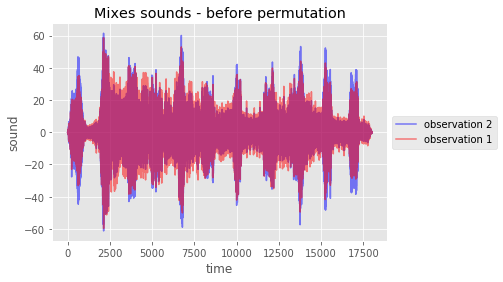

In [186]:
# (ii) Plot & Play the mixed sources before the data permutation
plot_and_play_data(x, 'Mixes sounds - before permutation', 'observation 1', 'observation 2')

observation 1 (shuffled):


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAADU2tfoGAJq1vwCMtvI96oAIOzW7lQkBtE94sr+yQGD6CDiHBOYE54rLPmwD8AJFxCQ+kLp4QhO+yYJyvWkGn4FH/gC9mzt5Owy/6P0fhbQ/f0NsgBk8O7xXBGF9oLpcAe3FCr/yQb/LkokaN6fOgoEfwekDeTsbCGNBZoC9y8k+tr96xsCAM4QJe5I2g8ECRCu9scAuwKeAQMXUQpmvLL2UAHeAZv3ufpd76cYXVDcDtsC/AXN6WIZu/W/+oPgluf2DwQALPlARvTmrPui4lbznADm+Ovvcwe4BRX/lf95IE0GuOZ3/2E74A1o/j/yCPUgFlnjqP8lJ8v0ItY9DID7qwb+w2jgZP8sR2L9vvE76M7090WyAA4TevXU9ZIAgRXDDGAvoxCMN7PM2PWXAjYMFPR/JpTyMPXN9Mv9LO2xJMEN1f9DIjL/GQP9DYHq+Q6k/qMJWhBkQTUbFu7bODH08/oMKqfbqwhJL1MHq/yy87LWy/0/IX8XJxLB/EYBqeES5x36pA8wC/EWsvUXAx7yrgqSNsPwyPnQAavw0wV89EYKXiOh31b/JQNP/0UHh/4n8If1Td1sCULN6sza7zUVZPt53MIHEeu6+xzdZ+v4OIHmuhS9/a/uwAdH5HL5rOrr/5ghCQkR9cs3qgOR+bv6fhazCIn3huLl908CMgkgOLIAI/YiE4X2TgztIgP5pBP6H4P5QPPxCuUw//54878IruAP+9j1txKeG+MFZlfo/RkAAfkCB8YS/wT/GGIVTQ/zFEv+l8qjRsrfE/eqBTsFFwPY/4EftRXGE6f2ZeZsAiL3owIbBsrlTTSRBfkOTBC4ASUjlu9S2nIRk/x5CkQI9OCN1fcBFwPo/YD3qgfuGU8LnRZs894IbwFx+tD7S94OAJv/NRVI+q38+gKS31YFAe+kCzcE19646F3/PiTZ4Gf8yQX0/c/+2SCd++v0GR5o6XD/5N2tEdz9xdZSCVUGy/34/hMPtPwGCiUDhfbV+Dju4wW/EM3+eda5AB362w+5ALH6J/wD5wfZayUGRhkX2/w2BpP+DAg94wUPiAyv90/zPg/4G7HgQiDoHGAC2AmdFpbRdu/c8gP39frl/Dn6DRTk+sMLkuwcAF/E7g9N4YvtHwURLvcOs/RD7bDjYOxdDiUKJAvUEiHrTSOvNMHuRgbX91jkZ+4v6EgGB9mg//Mctub09+b0+ubND20VUglY1PYTdvpADjEaZQIh1CcEtO0XA9YSKRTtASLc3P6J5X8AAAjgAZXzYAmK6RP+7yxDALgBUvxZHcUXjBae9noM2Pr6780MqPpi9jIzYPGG63sJs9Fc+b/oUwdPCRYLXQveAb8IpO4C7KEtavMNBcQ1E/cyDsvc+ejp/KPxTfVEIHvzTwSG/Z1CyepsCW7ks/0OJDIiHwRb8bEMWfH73T/+wCY7+/PrJQMaDgX+P94Z0DPwBQ2JIVoeku9sAo0VoBL6CenxFf1a0/T3LURNAhDrBvCD/bPuVhIbKBP+vvyJAscFVvN33qr60O7r8KUO0gOFFoj0dOljJQtIcAei9p/8bxYz+bzl+fY+3ZXzv/TJBSbbnvg3FK//SzjjBSP08v9U/skGqgX5JjD/IN7+F/4TJA+nHHAAVOa55zMeBQTxAagXgOczJYX75Nt7JyYraw6B/xcDoOqqRggXze5cEZoRtu2AKgAkx//XB2DxpQmN5IT8cBWzKbLzA+exzXj3TwmzQJ7qzQ0w3Uni1/cAAIReRgiU4j9XoP/w+s8L6hHk/4/Z8PsG/wjnadPdAghIBgw4/TnrwPex7zkTwR4J5HX2uBDH4SnPQ/HQJaH66f4d3VEkNQ+T24H6fw1n8d0Jf9+LFzT9P+58A4308P7V88jrMfKb3YfwXBHvJUv+BB3gFgUN/gk3+aopyvgN+14JZzImxDMYV+kF93TgQgEi/mkiv+CRGFLabyoK5d7YxyTL1XYEePWF7Hbss+4r9kEJ39Ir7PsBQe+C5+j5lQ8g50s71Pnz68v2wgrk/+wJFQzb9V8BxQaA5ZwFfREHAOISegKqAOP5oBAR/r0tv/pq/n4F7f0F82gJxRekQpQMzPWAGgD8rzVGFDsBcPMCAKkGmQWh/uUGTvDp/LgHLxJ23xwF1+sWCwgnXwf8/S38lQ8H2Wv7qS4k/uq8syJ3/aPxNAeFG7cPZEEID+NfXfYiE8n78ABqCXz/o/PQ/ZP8sylhGnEE5fd43/sKLhVG7rcIhP4IAQICjhn9BM72uCtOKbUEzPwG9mwA79Xr8en87yvX+UPxS+Oj5vLtMwvK+G7IQBJFA2AJK/wn/NS/kPoU9C3o4gbi/iDn6/Qw/sPxDAtQAZXxL+IIGlfw4/eS+CztWQR+FoDriQnc5/vrPOer2lwId/Q4988NUdsh/7jO8RG55/4UowJ/348KtQGbFpsFhSw9M43UBvYr6LvjDvzc9mL64vo76MAspAFH/7/26q5QARsERgSA6VPuS+kA+i3oKvIp/BX/4wl06aPx+wPI94sbuAMX7Sr/e+5v1KoF3gHFF5blbQmv+N70jPs+Lk/vWy6dzx8Afwda8p/n+PxGBIq4uez/EIkhoQtb/qELM/KE49zpffhvD0n5qwZ48yPk0k+UCq7kRg2D6+X8X/TBCPfVTDPT+nUmR/8R4xwr4QWL2UIna+oMBvoCDfJr8GjYjutEFP0B6fyyKjn/W904Br34UCcT9f5LoOfXK50VqQy4+FQVUwexA6z5O+hP80AOpipiAAIApQjzC54/Xg9c8rr54jCO9zXzmuaHCaz7IxAM+nogQyoC+DgX3e2mAjv/ZhnNCIcpKv+9/Q4Amxpn/7LWh/U0CTgU0w5G9yfcFd0jA5wXP74X9jf45CkxEyAwygQ2A40AufpuCQ78XP3VA0Lp7gKo/+Dg5eXsDYfu7gZIAI/nlw1r/xL/edZB7xP8TgMh2c3a9AxGEpz4Uco8xfG/gPtCzqkjeQE+8wzIWd+ovu0D9eWv7bEHYRYq6EYEFCeV8xYNkPgt+HEGMQPMC1j0pQiWGpD2uCffFJD81ROBE1EMaf04+0UDHvlt+agJSuhq1r8Q3ANfA68hoAcSMVjsBQ/e1eAsRzQN9osC+/tpAOoB9CgKLC0iWv6hDbA1lwLq8PL4JfmO39ABR7y/9tf9LLXlDU33MP6l+xnBUtKxzcYaDvqe6vsB3e8+9RT08wRI/A76vujUEkUVQfxB9HT94PHy7M8JtwJPH+gMo/GJCSr7Mu9MM5v5D/tM9mvdCdDt+5PYPg6XDrr5zPwi998UveSc6u0emg3V/xwX7QPS7sYDVBm9EJsFOQ5l6Q0FwSoABu4Vuuv+5HAH2wRI/IcUVAak7g2+4uGH3qYC7e1uCcHua/Lp/Ab2mA9Y9sUAgr9wBd0CEOqkAWkFfB5fAVQBx/+ROtTrKQbN9S7r0NEv9ChO2O0MC1bzjBaE/MsGpulh+ewGIBpXDYgMzMlF5U/bGvz5B6wFJgKN4iwloOat/lcLwuBmExP+uuvC8d4BLfby/8AQGQH6LOj9YhXJ9nEl0vKQ6mURFfHtATUfK+R8EQYQmLdP+AASguvN7O87KDK3BuoRqgD7Ad0ek9ge+TcAkPJr/6z7tObI9yL+7i6Q//nTtyxADjw+BwKIDr/9SAAZBQgKPf7ZsP721exnC3cej7+oE5AhbAkL7QoLUgEN/+b4Wd3317Puk9o0AgX1MQo+JkMZwQiz+PIAA/mHAjcAai4DDE367Qie6NAITQ119OYvT/8UCnAA2btK4fsKWhBx+jvoA/ld/gD8S/6661rmP/d45FXXA+dY+JjtawP0Dv75Ntn58j8NDgKy8cjryvzyCZje6trI+f8EDPgw

observation 2 (shuffled):


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAADMylTtugF74JQCauRh9YoAb+Ib9OAhFdyQ6eP/UAFr7mjpmA7wEmAy1vqUCzIHhwz/+/rh+wVv+/kF8PjTIxUEJvo292rjaPGt/3Dt+RAsB/0JKwDO4q7pIQ3M+AfvoAUwDDr/YRWEKtYsj+ZfLG0EtAVHCmjxNRkpBHMAzjivATL+pxTPAL8MkfKl2j8Dcgyi+LIAEQI0Ae4l+wdXzZTlBwFpAQkN1ftV8m4ScD00C1oEMQH68N8is/dsBTnaSt27DAQA1vo2Vgbtw/wd6l/0dgDY+uDzBgZlBH8BJvEdF+APeO2lAdVY1QmU/pD1FfXJElXquf6tHSv3rcK5CIf8KwQ+twXniv8TNsfrBfYG7sX0TkIx/oQOp+R775cBmg/kDzkxggxCOhjK2/cIAg8W8/amK8v2t/eR9x7+zPFuG3AKxP8kG9UAwQD9CaPvXAtQ/QoHKyvXRG8UffJ3Kxv3Jfy1IWjVFRtaJHgFk/rN9t/gJPy7GdMQRA1v8oIIOeG+6F77vQonDZoRsdtWAh3iIQpdQpLxTPtVATbyJwQZ9eMNszJ853b/agIT+WQFI/9t8zD4y+UgBz3Gbbn1620jX/yb0HUGa/DX/F3ZCd2fK1LjERAK/qz0GQKf66v53+9zAXEZgxJS+ElDswJj+zv8+RCCBl37mtrW+aQB0AZyKisApvgDGcz4MwmFGgD7vgP4F077Vf0KDDc//v599jAGLOhN/Nv3DA7bHqIEV1SHBiMAmvqjBCAOxwMEHjUQsBPRFJX/PNYVUz7eLvmFAX4EVgIqAG0O9B6hHncHP9vMAUL53gKMBC7sriZ1FFwLCgxjApgb7PVFyeIRMv3QB4UFU+kYwT31VgJG/kn50gBuE5cIXxDP9r4GkANw+9z1Z+YUAHT/NwNy+sb9LgJo58wH+/ipCBUDL+zu7e79pBlo6Pb8twP0/Wn6zDCv/Mnx6BYc7qz7TORVG5n+t9FeBwUGHv4/+oMWIAAwB2oCzPg1+bvlogSqDCH/j+AS/W71QBOeAKoHsfQa7Y/i2CHiYCAvlv2X+dH+Fgbc1vYBgwllAKf2wyUhGhTWXBhXGB4CZQVfEN3crOIH9t35Yvvj+ob7IA8R/DcJvPEoAIHK3RwI6RHrBgq/JR4M+Pj08BLOa/jmCqQRWwg0DmTjRRo4QwfzyATC+fHqmfYw7f4Wj+KG/UUxMuHq+RLpsNm8C1MUXgdOz58jH/e+Cg8g8AByw5sC5+pWAnINSQ9+AfPkc/iC6U4AaAaE/aX2owx46YL+YC8XAK79+/+5KvoRDRGs928JY/wd9eojJ/729jwo+ubt7jQHBd1a/KbreAX4BkcIkBJpATAGVuT08HosafbbAzA9LvmqCrHZ9+uq/Rr13/c2Lwz4awQg/lJSB/AgB+jYvADNKYopvO+29G0SGOgE37/+IB2J/ODwagKMBHT87eD0ykT0iQ5dGcYnv+rMAXEQ5A6CBxj15v0kxer5ATU9AXzkB/+1//PyshZxKYL+bv30AXoEX/Sj5un8G/PWBkoLiQKyDoDu8+43PEo3oAX0+LH95RB28RnsbPm35aX2VPa3A77QdPp7ESz/riqiBAf3a/jL3mEViRBxHYX+K+ZKEgwPbBWrFToAVtxS7RMxoQP//dIRAu0iHHECcNg8OQgp+gqy/1YCCO9fNdAeG/4hDTb+lfGHMwsssP94EPrm+hKz4x79SRCuH832Gu2K2rr5+Aa+R8vvHQqj5dndwvkAANduZgaj3g9nhv2+++UIFhjY/xzSFvlgBd3g2d0GArlG+AnfAgveH/qQ88AOxzNR3Nf3Uhxh54y+MvS2JELwSf896K4b6gql58z7LhGN9VoHLNeqEUz9U/LiAoXqzvzq/qPwVPSW4Vb0IQ0nHZX/ihHXG2sJygif6jImbvJz5QwHpzSprc0Ry+6f+Hbc8wCX/mkt+tahFEXJfiaB3JjL3R2e39j0HPgp4tLq8/LB4eQGf8Ly8ZIBzeSR7tv70gtC7ao5//jg8Mr4NQjY/24H4whC+PT/FgWM7Nn7exkBAEgO4AGKAEnijBMc/vg9bAX7/hUEDQFb7pP/+hF6VzEJLvgiEdX8mShxD1IBDPzPAO4E0gXl/qQFBvSq/QQG/x8/5+oFt/BHCK0eTwZ6/oAK0guP4pf7Pjv9/iy0NRoM/hr1NgmAGUUfZlFwCwxd9vgDGev8HwC6BkcVufYsBzL9rh8PFJwP1vmZyIUIjCSk9dgSvf6jAPgArxNhAzD5czQhHyYEgv1++AX/9MV+9ar9DDJg+zL0Qepa7ajtbwiw+iTQ+w0mAnIH2vAK+xW8D/Zj+/LtPgUc/0LtyfGr/orw5RJ19gb1fOldI7P+R/jG+szxm/z5ED/wSAfW6VDrau0ZzgoGGffl+IQKfuEU+u67Px1S7Y4fGw0s10sD+QwhET0ECz3AJnXTfvi82wDn6fxE+Vz7qvsG7nclGQFi/xz5UZsHAe0CKQPJ76vkRvA2+/Ltb+bU/Yr9ARzz7hr16wWu+TcoxwJx6jr/q9HR4FEEaQH6Eejlkwvu+gz4NfznImrzDyMC0p4UtAV79hbqvv0pA+/OLPEFB10ZQgh5/kII4/WR6mDzIPWBEf76VAV99m3r41iSB2nrbB354af9vveWBpG21CaW+y0bYv/x6f0zOwT3ytUdW/93BFcDoOwu9LPhU/DiDWECqv1oKE7/3+W0BNr56R2P99ZcrvUiJs0IjBNJ9yEQeAUgBST7Bu6T7b4KoTsmAGYAbgZtGjgw6Au59Tj7qSm3CLz1+9XiBsP8NAyt7qwjxjb++c4jLfIcAoz+BSpEBnEfOv+IEBQAXxQ2/YTOMPhqAV0PCxH5+KjKfNosA/sQnbD4+Fn4ETP+EQ5C9e0SAmIA1fsBCOn8lQAmD/rhrgG5/n3h3OLVC7fy7ARkAEXbrRPf+ov/j+BW87v7+gQ6x97jawypDA76Z9coypq3jPqSwzYt3QAt9srVF+d6v0UEauxi8LT/0RC17ikDCRyl9uUJYPo6+gQFbQJ/CKXsbgaSE1Hx/TXmF539+RUlD8IK+P0j/CYCwvrp9KMKGu574KoMBw66Al0O0ge9I2zx9gELx1con0iS9HgHX/zI/xcB7yxmOqgwjf7/Dv45CAJ89Ib6bO0121UB1bQc+fX+VKbpEH75q/7n+1PB4t2K2qQhUgjL75j/zPPL9/P2GQQ5/VIITt80Dg0QXfy74y4JpOV88UYHmwCCIGwKGvVIBzf9QfPUJoH5Tfx8+GPwMse6+jjUgAs2Czj7gv1C+Zwcfevf8kgXhQfE/9YRRQSC89sCXhNEDD0EqQ7f7tsDcS/KBPYrj/CG6aAFVAM5/dYI3ATf8hfOQtv15RwC8ORTCgfzzfWq/X74OAyv93QBkc4BBAYCkvAZARcE5RUi/+X1sP9LLHrxoASHCpPwLd3e98dQOPDlEl/0DREe/RYD5+x08Gj/EQ9YEYMJ7rHA+V/qp/b7HZr/zgF72TQ1He67/wgD/NToC4L+j/Au8mkBvfJr+NMN9v/HJUb+NRA36Po5RfO379gT4fV+AawXItqQCwwM2bvt8vMPfe+m6QI5LjgCBYMNigCSAZocONTC+oH/vtz9/8P8weSu+Zf+ZiXG/6Le3iO+CnVAPwFAEHH+ZACJA5YHRfU/xGz3VPHiDbUsu8CUDjIwIAdn7JkIVgRBBNj6s8wQxPPyjuOkCHv3CPyVHe0flgYp9u4A2Pm2Aur/IyN8ESX00gan8aoGzwnc98UrE/ltCDoAiKBP94UIHgxw+wbu2Pk68NX8bP6P8PbsavlM8dzNGu3x+rT02An/Eerwj9Mv9pII2wIu9aPw7v0cCYHMBuRM+8cDJ/Qq

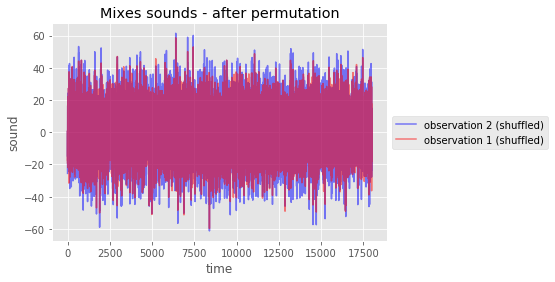

In [187]:
# (iii) Plot & Play the mixed sources after the data permutation
plot_and_play_data(x_shuffled, 'Mixes sounds - after permutation', 'observation 1 (shuffled)', 'observation 2 (shuffled)')

source 1 (regular estim.):


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAAADAAMABgAAAAUA+f/2/w0A9P8aACAAGABOACsAHgAcAAYALAA6AMP/EwCv/6f/PgB0/0cA4P/9//AAof96ADAAd/99AW7/igDCAJj+XwL9/bYAfQCM/TADj/08AJYApPyFA3b9wgA3Anz7XgVP+5IAuQEJ+aoHOfnWA/UAKPraCQb37gd5/r/7bAnF87AKY/kT/tQG0vPMDMn0uQQGAgT3Tg068oAJRvye+xkK+PJ2Da33PASuBSr1tgxQ8g0Jsf44+vALdu/KDCP3GwA1BpHy9Q9d9IAJg//9+K8LuPHxDL760wFrBbv2nw3k9DMK3fycABkHDvfTCKf0pwaQ+xsCcv+B+B4LRPO6C1D5NP+nBfX8yQjU9XENOvY3BlEIjfPgCl746wMZ+ScH1fhC/KISm+h8END9U/RqEOP3W/0QArH/2Pj9A20FwfFBEFsFSvbRE4/3rPpADg/8uPbwCZP3nPPXEhjxJfiTEGfy1QGlEYzv/f0vEM3xMgIoDzrutwL4EFnxOf5uERnsfQNpG5XfngZCE4PeUxKrClbfrBF0D+XgwhKaB3DdLhwOCLrbjRs3A6ffUSjC/O/jUSjt92jleShZ8MLoaipd59TtpSYK35b0hypm2rP8hyq11gcFGClPz0EPOiwry8QaQx4JxSki/RKSypojpw2vzdEk/QfMzcQqLwbq0zMukwFR0osrT/3ezC00Qfkyz38/gO2V2FNAYOjT4Bk6Necj4eM1teMq4R42fuJl4Ts2vOSR4qU3z+J651g42uPL66svKOOS77MujOfU7lwo3+tQ7b4orusO6MksVuws6AApOelv5jUsPO1A5L4rwe6C4SguOvBs4kUsNfmb4ponEf5Q2c0mZAIM2nIjjQIc3CcaFQpx2kASUBWV2w0S8Bhx1K0OFhtm1zsPQx7f17UKCR7/3CIFTiA54/L+7x5w4Lb4ZyJz4pr52SBe4cv1aidd5yzuMCoJ5vHqATBI4dbo4jFS5PzqjjBx63rm0TJH7lPelzKZ8ZXcNC8B72PUhyyu/BrRMCokBXDN8iZ8C23MYCHsE1/UIxnLFUTVrQ4JGhrUSQi4IADW0gJNJzrZB/uzK6jZwfgdLEXZrfKpJf7h5/TjJy7lk/BCJ/PsxPLGJefyne3jJGjveueXIT3yLuO0JN33q9owKjP7ftiPKcv+JNgMIqIN49LLFRYYDtcLCogjRN+E+vkqquQN6/gtDu+V324r6vUs1X0mngZc01EbbhGp0ssSOB3v1mEGoiHE3375HSsY4WDyQTCN5BDwXy1D7GjlACvZ9kHbHijQBsHMGyG3E2PGJh2iH4DF2xRCKk/P+vtBMKffNe3uNQDqHdnyMI0CBs4xITwU7MffHDYm7MRDBIgxedYt8sY1ldsK3AA5RvPGz6wsxgp7zaYg/SOZyn0IRjYW0/TvxjW93+rZUTVA+NHFfCkRGXXElhTmL2PFgvx/QofXV9zwQhLwN8TBPeYKXLX+LQAoDbn0C5I+CcWu6yJO6doZyp9MIv0VtNQ2RyIirJQdREJpszX5xVjpzHnSoVh28Huy6EfCHDiimyC8RlCriPYhZSnCncuYZenvy6i8SZceFJowJBdKVKhV8gphbcyvyTlfQvpNp9ZFQS0jm0QXElm/pKrmE3AZygK4BGWXAsqUrEcbOwaVYRP/XxarHdk7cbrYmawrYb0QU5YZOjVJuZX4Aapk5bffyZdpBOxKodhSKSihjWciPFqBoA3rZ3KdyNOytGuiAiOb+0BmOnCauwbFXFm+Ccs+ZQbz66LmTY4sU5QJHT5bHqBe4OhofdFBs9dbPw4QnDc0dkruqH76zF9BzTPJlV1A/b+ktznGMh6j8wWeTwnFpNpJVc/3wLNFObMrXLJeCDVKzMqP1GpW4/O1tYA8ayYftCAQ+0L4yJ/jNUoQ8k69uDNDIPe27wvxPJLK9N5cUenyKbw7Mhsg8LVKDmBLKcLX3shQwe47wRw4xx5ctbEMGEd1xKvaUVC87Yi9tzaqHHuz0AoNQ8zKg93zSMz7k8AVMSUntbh6AoxN6c0H2IJG0vXRvzosTSdKvEL+6USD3WPSpD0sBaa9YCPyM+C9oO5xR0vi/dH8PBkLdcMJGwovFc8A7Wo3uu800nwpbhE2yqsKVy5x23LppTb6+IjRHiUHFgbOfwamKpjkCePbKzYDu9JoG2sjs9Vc+Ds13+vp2tUmqwca1MEOlyHW3+brQiaq/KDdFRimF+3b9P0lKuTtC+DcJfkGVNRpDuEamd1Z8bgjX/mK33ca2xRP37EA2SBL7OHkzxy+CX/Z/whtHjXkDvJDJGf9it/3FmMUvONL/sEfEvA857Ubtweq4OMGURsh65PzFB7Y+bXnAhE9ETzq4fl6FWn5F+6RDy8MVelqAK8YdvYX8W4OggE+718DhwuV9oHzxQg7BG705P7ZDNP9bvY5CkEHsver/94HkAFT+MX+Pwtj/hH20wf/BSH1gv+DDSX+lfRVBZcH0/hp+n0E+f8x9qn+0wuDABz27wnECBb4MAAcBoj/FPzs/kkC+P9j+eL+5gdf/gb5jgidBGL6jAGoAeT8+/3ZANoBdgH1+R38igY0ALP+hQW9AE0AQAMu/8wA9f9u9+b+8AYc+9j5gwXe/aj8PgXN/9cBVgF7/DAEDALQ+kYCKwQK+mP//AK9+rUBMATH+zQALQV8/i3+fwbO/3X5xwMMAG33qQPG/+j1DAWmBT/4mwOKCWP3y/51CTn6dP7xB6/5j/r5Bsb8I/xVCWH/Ift7B+H/NvnzAlcApPjgAHoE2vot/tEG5v9Y/oAHBAFd/JwECgH++ZEAGQTP+V395Aa4+r36kglc/zf54wa7ARf4KQKjBOb3E/7YBmv7LfuQBUr+4/pVBqMCovuWAsID+/oc/hkDBf2L+1ICiQDV+rb/jQIS/00AZgN8AVn/XQBHAfD/hP78/sYAbAAH/oEAqAEB/5P/NwMUAa395wEWAgL9Pv8nAV39Xv7pANj/c/9aARYCLQHaANEA0f+5//X/igCz//794P8E/1H9AgHyAET//QGpASj/6AAjAc/+DgAHAXP/BwDZAC7/4f/JALUAOgGIARsAJwDyAI3/R/8iAH3/wv7D/1gADP9P/wsB+v+M/wYB5//A/v7/q//7/aL/twCj/tf/FQK0/3P/uQFxADX+s/+7/yr9kP7Y/zz+4f2U/8H+kP4HAWsBfgDbAQQC8v/BAKABHf+Q/sf/R/9W/hn/X/+t/vz+8gBfAUQAgACUAOP+Jf8NAH/+3/4dAEP/lP4DAMkACgAUAUMCnwAbAD0B8f+E/mj/kf+6/gT/HQB9/wv/MQCOAPL/igAHAcD//v/fAGT/Af/KAHYA8v7ZAKUBUQB3AX0C1gA8AJABdgA5/9kAowCQ/on//v/C/nP/KAGfAGoANQGZAO7+tf/g/7r++P47AL7/Lv9DADUAuP8HAaEBdgCXAMYAjf88/pD+g/6r/dr+mv/s/gD/rADBAAQB3wEtAfr/5//D/63+Ff/S/qD+T//D/+v/8wApAWUA9v+1/yX/pP6g/vL9Uf6D/sH+r/8gAAcAhgDLAcsBywFsARIAAP/8/r3+Uf5u/oP+pP7f/t/+XP8tAQECBQKuATEBfgDD/0//qP7W/qD+xv6r/xgA5/+4AF8BSgFsAYUB7gDw/6//cP8A/xn/if/S/5z/jf8nABgBTwEUAd4ALwADAAcAYP9P/0v/qP7K/hwABwDd/08BZwFtAPr/XQAZ/63+3/69/vb9E/4u/6//DgCTAAsBywGeAS0BZQDO/y7/xv7j/kv/q//S/0QAPwDS/wcARgHeAEwAAwBX/zz+cv4u//f+4/6r/7AAwQB+AEYBrgGu

source 2 (regular estim.):


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAADM/8v/vf++/9D/2f/N/8D/ov+S/1T/Kf8S/9P+av/L/4n/Xf/5/zcA9gA1AfcARAEyAKMArv8G/2D//f4YAK7/R/6e/y/+EP/p/7L9agGQ/l8BNwE7/gsCQ/4eAtYCt/5YA9T9t/++Ae37yQTL/u0DPwUt/mIHNvoaA2cAXPhdBNL0BwMM/Rr89gZN9hkL5f4BA+EIbPcxDJn6PAZQAvP3ZQtb9agJzf4P/ggJ1fTjCff2kP1oAKn4DQ3Q9fgGtf4I+04MUfbfDbf89QKdBpn1hAg18bUGxgFv/IkLqPSjBwj4hf0gAFP0dAUH8pAE2/dF+JcBffvlC2H95gtN/+0CPQOC/F4KaPZBC0P94v+rAGD4EQLW8PgEEvEs/qEAJ/UfCVP6rAbM/WIJcv5f/m4N0O3uD7L/wfX6C8z3zP8xCEgGAgLOBVMDZfCsAW3zq+mcB6zz7/r4C5L7jfs0ERwDWgGXG3j92gF2EIzwnvgzCsvzrwBCERv0af6JCN/rRP43Dbvzav9JEMbtP/6rFODnrgmnGRjsOBJQC9ToExG0DhzqNhQ2DebotxndBdPgxhROAS3gXRb/8SDeXRaC8ijnKR3J8VXuVSRG7gP4xytt8YMB4iOl3vL74iNd3qwGICK90qkAxhVmxQsJfxG+zsofTxOY1oUhYQ4n2SckiA202PQiHQIg09YcMwLX4LcuJQhc3BAuPPow0+steur31qgq3eKQ24kle+cn6SM2RPV08Dw1o/KO78k0N/Hx6jcv/OnT7XUs4OV/7d4lm+gl8UciIeap7Jwd5fCg8oEj8u2L62giEe+k8OgpoPfu8a8kOu+364QmW/Qb79UrRPIX5AUdcu3x2y0ZSPqC21Qc//4G4LoaAAO45koanw3k5csOIwr52eALqRff3xAOmxai23QEfxHH2a0EZhLR25v73RDw4Or+rh3p6z7+1R5k627+jh1B6A75UyFG7qn2PCUY7I30qi8B8LvxRCgF5I7l9xrB4+/ilCQe6//deyWS8N3k0TLnBezuPzL+BTbePCU5BhzaLiNRBUfPDxSABFPRdQ9fE6LcEA6+GjjhggoPHibhjwbGIULj6P1FHyjaXvp3LIHq2/4/KDHt3fh3Hw7o4/CHGvDo9OuNEbfnB+p1HID10+0LIt787++aJLn//eQ8Jdb7vt5MIKv9H+A+ICwSl95fE5gT/NyWA/kSSNpq87oaq+IC6bwdwuvg5ysvsQNq5Pskrgm73LQVBxJ9310QmxV33X3/CxO630/5kyHo4TbxjyMe43/rGSCk6yjnByJ3+q/ikR4NB8/c9CPaF0HYTR3sGurM8AuKHb3S7vaPIy3g7eckJyXttuPzKwADzdc0HBgSNNL8FqoeMc++AqUpS99p+ZY2N/Bq7rI4fvwH3NsijgIdy4MPLBGnx7z8yiVj1gv3ljYV9mPvYzidBYHa/icnFwXRtxD3JF3NAPnuMCHb0uUDPpf2+tHJNGkKZMIRJQQfrMI/BpQxvs7y7WE+CORz2FhEggNux2wyVx9DujMU1TE/uwXz8EBdzWXRgEFW8ee+QjlvF9y0gx7fPX+9//f1UkHLfNIhUczvmrjiQAgf3q83H3o/broW9ddMR89ByyhFbvSnr5cyjCCzq9QWlk66uQjxI2Nz2MjGaVPqAQ+nMDplMCGmDg7yUGa+tuOUXtHdbrhVTKMJAqGJJSM0YKO9/8pUO8dZ2Qdfv/eEuHdJ0CWgpdUe/0nJrALp91l5z429s1bTALOr5TYuM3WuOgnWTnPLw9SCUlvyGrJPP04j46jAHdxUIr2b87thG+Sxyn9SCwwLqBAfLy89qfTt6EIDzCvNoUtFALq54jWTMyTAKg5bR77OsN3XP/Xy5bnNKEUfYr9VCAc/sdVr3zlKXvYDwekqbxZuuKUEBC8RzsfmBz/d+Y/P3S/cH+PKdBH+N5jW7+J9QM7yPMXjJhEZHcArCGk6Qctj48RCW/TpzmMt4xZkwsMKdzwF0f3kmUSs9KnO3zI3H8vJKhKQPbHVNOEmNe3zrMJMIPoaBsRdAq9AQNiT4MY+WgB81AQsxiG6xHH6PzY04SXZPDXzBzXObCL2Lk/N3PQWO5jkTtP/KG3/IsZjD+4go9Mo8B0w8fdK4f4nBxIA2FALsCOJ2g/mUyTr8xvVjhtyEs3XlQRoI13qFekQJhcEy9fsDWwTgdOA9OYp5fAI5KEjFws44XYRCyJG7jL44iXM/8HgDA4ODKDYKPX9HVjwC+YLIEYIUuDPEtYesu+t/BIhyfmh4KMR8AuH4VoAjh3x8qfwpx74DpvpRQ1EGHjkxe6FFzH5oeDCDssNU+Yr/HIal/bI7pIbwgwD6+cEtBVo7OXzpBl6/ezs+w8VDzfsofnnEHz7RPNADlkFgua6968LkvRG9gUPHAfb+RkIWQ82/5j7Kw6qC7n6v/1wBnP4DvAEAeb9afOa++MCUf5Z+Dr+CAmpANP5wwa2BC31K/2HB+T6o/OfA7EHy/1FAaYKnQfk/m4BwQbO953td/6C/bvz8fpDBGX/jvxCAsAH7gZfBOUIMArH/Jf1MACU/n/52f7QAq4B3wCaAfkCpwIG/QoBSAYy/dv27fvo9i34dv39/TEDMwS7/Q0GHwxMAZICLAyy/0f6ugCf+k38bvzN9lL/WACE+wUFNQhrAHMGxweq/RAAUv+O+TL9YAJU/J78lQQqACj94wc5CE0D6g3FBpv4kQCEAPP01/63A332q/3lBUf4Y/1QBkH8w/9GCJb8JvjTALv5afiRAgT+Hf7XCCYGXAD1BCIFN/1o/3oBwfZ69cf+/flA910BZAPA/kAFVApSAZwCcwr6AKr9cgXk+4n45wSpAEf5rgJaBuD78wDHCDr+Lv9FCJUAXvnS/Wn8SPgo/98CBf+uAlQH9QNKA7AGrgSHAKEFAAMF+i348/vr+sr6a/7VADD/r/+cAPYAVwIRAvQC0AJM/eT5hf7r/fb5cf0LAnL+6QG6BZwCMQHmA9wByf7m+4745fgI/Bf94PyO/2kB5AHmAiEDlwNWAvAA0gLm/i76yvpm/oz+/P/XAe3/tf6C/8n+RP/R/v39BP6t/Uf6nvmX/B79APzm/p8B2gAaAkUDgwFAAbsBwAGUAsMBGf7e/koCPgDC/iMDLAE//zsClQI1/xv/Sv9U/cn+iv8H//r/5gJQAhQEIwSmBPUE5AWcBkwEWgGC/wr9Vvh1+f38X/zz+3X/awJaAYIDowPHAfMCuAPnAJwA5v5f+437MQDNAIgAngRHBAAD2QOiAmIB0gDM/639c/wh+4/77vwe/SP/8QF4AqgC4QMZAlYCogJ7AP/+ewCU/l/8HP+C/zb8kf0LAWcAFQBvAH/+6v7R/iT89vkj+Vj4Tfmc/FH+f/6w/9H+MP9aAScCIwODAcn+h/7u/Ar6af1GAHL/FQCXAxkCJAEuAgf//f0fAfX/zPy4/Kz8tvuE/fYAnwH1BHQGuwVDBmEE0QJCAt4CIf7z+/357fg2+xn+PgBAAbADegNwBUcFlAJAAbf/HPy9+1v9of4VANUBwARHBQgHkgW7BUwEpABZ/0T/2vxR+FH4UfjH+S3+3gJmA9QEkgUeBbsFwATZA9kDdgE2+/L3avfE+K76cP1AAZQCOATpBEcFxQMsAWcAPgAD/V/7wvrH+dz5pPww/6QAEgLeAvMCJwKj/wEAnwHK/pn6O/oh+4D7uv3M/0T/7gCUAhwDOAQ9A+D/RP+M/jv6T/rF/Bn+a/7zArAD2QPUBIEGDQaPA6QAtf4M/jH8Ufjw+Tb7W/0qAI8DxQNRAxwDLAGj/1b+3v6j/0T/SvuA+0f9zP/+AfUElwSPA+4DUQMsAZn98/tw/Ur7xPjE

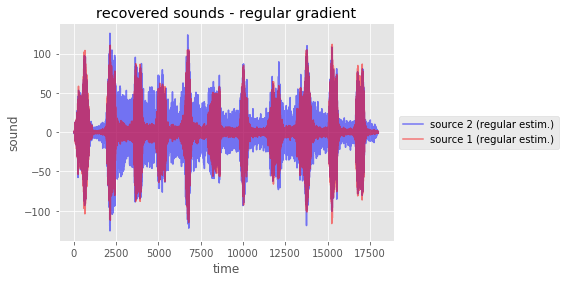

In [188]:
# (iv) Plot & Play the recovered signals using the unpermuted data
plot_and_play_data(s_regular, 'recovered sounds - regular gradient', 'source 1 (regular estim.)', 'source 2 (regular estim.)')

source 1 (natural estim.):


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAACt/6z/lP+c/7L/y/+8/5L/ff8//93+ov5M/g7+AP+U/0X/3f69/48AYwEjAssBsQHSALQAo/+H/ij+0f6w/1b/5f0A/sn9EP4k/9j95P+8/2cBYAGn/xEAsf/+Ar4DPwG4ASD/2f6JAB/+JgKiAmkFUQbcA+cDq/0NAbT/+vk//Zj3DP37/CP+lwHv/KgGnQRlBvcGlv5PBnsC9QSVAVf8ngT3/JoFugE5ARYEd/svAjn6Rvg3+y7/sgeU/fQBSf/3/UwHDQHdCHMDYwQfBAL9u/2k9CEBKANDAV8GZPxF/+z4gPoK+x/3T/ti9Tf9ovax86j7rAGkCdMGtgsoA24CcQXVASUFkv3oBTUClACk+1b3x/qw8r/6qfJQ9wr5Zvt7A6j+ZAY6A2wHdgQXAaICsPp3CJ4BlPuKAkj7NAJ1CtIJ3QkBBeL/5fUS89TnYOev+Fb1ZP2XBAn9FQKiELwM2A3pF1kKSgowCYL1DvOt/iX99QLFCnr7f/uF/mTyyPrjA1f7zQAbCE33BPpCBUT6YQiTFK8BMQoAB/P7EgmXB2n8ywzMDN39LQw5AT/zSQXs/ofujPvZ7VbnjPs686LzswVY+VT7uw6R/C4Fmx1ECSkN8Q008f/88Q1L9FUFpAyz6X3y7fZq2T70vP1r7bIPNgsP9PMQzwj69MgT6gwv9E8MU/3n5cP/1gE6/Gcd6g6e+jIUrv196jQJ+PBI53cDTOpq5qABafK6+tAepgrFBTod0AcwBHAchgMU/KQSZfrH+8sNLPMs9w4M+fcd+YoHCfAD834GQPyA/RAP9/fF944JCflj/4cY+gj/Ao8NbPim+8YQwf5lA4sWL/rT8d8BU+pL5X4AK/l77QgGM/yh88sGIALS+/sODgsn/BAFF/v+6NMAJQy7+FwHgAh+70P4vP067Oj8Uf9x6nP01fpI7Fz/kg+T/0UEBA7e/LUDjg0l+S//BQ2R/M4CURCG+q0CmRr6BGcAlg3p7+Xrr/q76DfsGwcz8XzssQhP9o74IyAhGZwP0iFADGT5URCKBKn2SRAj/TLnp/7f87zihf+jCArzXAfFDxr7DQhyDjD5QgfQDVH5jQHUBRvrW/5yGUME8goxGQgAvv/BCTf1w/fdAijvMu6s9qLnLvALCN//x/uoE1cIEAOTFFIHkvpREEH+K/NtCZ39mPV9EJUORfijCMoG3vHi+/b69eUj8qL/ie0S8VcBbvFE+jIeNA/t/nQTYQgB9esGwAra+e0G9AS18if54Py97Qz84gnI74r2AAhT7hTwfwXo86LzrQpRAIP2LAg2BGj7BRdpEY/6sRC4CjTqQf6UBLPpE/YACIfuYO0HCFj4HPoRFCACmvIuCy0I7O9gByMKNu4aAAMQ7fUqA5ofuQqOB7sfygZZ91gKoPng33X4y/df3ffypwWk668Bmh+qDw4LxSLlD4T+KhVBC23xwQV5Cv/qtfjqCpruPfpWHuQAG/NGFWsFnOlwDPcIhuYZ/qIPa+339zwU4/hS97keDQh38kgY6A4P5nsCgAyg4Mjy/g3V46bk+w6N+A/nZRIrCE7nPQ+CGr/r3/yPHd7q1uxYGr32ueY4HPERe+fkDL8Z8Ol1/CwYMue040AO6/OS2kEKSgYo4HoMZyJI7GkBrStS97/tWh5vACjfBxQjEYfd3gJlH1XtHPqqI4nx2OJIF7D+htSgAWQJrti6/cYgie7o+J4rgAa87ZAgHxPM4wQOVxqw3BLxjRsg66/k+hzA/ijgZxUJFgHllwdEH8vu1/DEHKn3deLeFSMLYOJ8Edop2fVPC14w9gE0+LIltAS62Wr9rwBLz+DpSwp14RHnoBkIA0jsyRrkHY/30Q9vIGvthu+lDwX0Qd5dB9QF5uerBPQYefLw91Ee6/ww534Hdv2u27P3jQem6ML09Bj0AwT2XRedEfj0HA/qGg/0YPNdFHP4cecqC3UHmuXK/tcQ3uor9F8Ywf5M8W0PagWc6T8ECRht8ZL6lhszAG/0ExkOFJ/2QRGLHXnyIPIsC7DxXN9DAqgD5ug6AUoYZfNi9hccOQoX+6gY0A2N5jr5rxAg8n3wERYhB6TziBLHFQ/ypf+cFbfyBOghBJD03eGb/SoFSOsO+joURAMF/SoVwAqI9gAHAwr86R/uFANd9C7rdgYBB5ryxAAaDUb50Pj8DyUDHe4J+8D7x+TV9eAMQPzj+BQRhAka+3AMqBO6A0sHCRXcAlXxYv7H+57mgPFeBX75DfeQDOgFhfnQDi4VBAjnCCgQ4/xS748BQf7n8OH/jg30/okCERNuDa4CjwvWB7PwJPMnASX4Uu+GAIQB9/PQ++EJ5AB1/XEPAgz+/eEA6wYm9nn5QwoHAjH6DAh3Brb2KfwxBW3/u/3MBoT86u4O8zr6v/dx/woJWQmhBhMJTwzEBzUFJQ2pDQEDpP2K/Z/27vDQ9+f1z/Sk+eT89fuz+3v+/gKLAhYAzwJxAe75LPyP/gT6HvhrAHAEegM/B+ELkwunB3MD/f4V84jtOPTf8+30JfimAIj/g/50BJQJiwruDI4O7weq/Nr2Jfh0+Xz7x/ywAoEFPwOfAb4CoQI8AUcFTgOO+1/zkfSA8dnzDfm6/RUEaQa3BDoKxwuhBsMJNg2QAYH6HvwI+KL4UPlm9fv6k/4j/nIFewhQBl4K9Qh3AXr++/o/+o77rf7f+5v8xABvAOkBXghsDCwNnhF8CmT+D/xp+5/2z/qP/Mb5nf3x/8n5g/0EAlQA0QToBeX9xvdg+BX3IPnH/Bz9mAOZCgAJjQevBoUDrADVAMH7FPKe8QL36vUx9q/9JwTTA2sHwwvlB3gGSgmDBncBJv9g+iT74QBc/1X9AgI4BXMBRwPMBqoBWQM/B4QCz/qp9gv4c/hC/McASgPdBSoI2Ag8CfAHlQa5BdEIIALR99nzn/bh9rn4Qf0MANT+7gDlAbkAJQMEBf8DsALa/CP3sfrQ+w75TvocAXwAnwOXB3gGXQMLBfkCr/5++LnyG/Qr+c/6cPuX/y8CWwKvBKgGkAV8BPsDUgNt/d/3NPb8+5n+Hf+1AQQB/P1G/q/+2/5l/br9HP26+6b2J/Ve+Yf7yflt/eMC+wEPA3MFegMgAkwCkAOSBK4BI/22/oACdwBN/8UEGQLGAL0DPAMXAMz+7/w7/K/+qP0a/qoBrwTEA+MIpgc0BzQJ9QptCrUHbANG/in65/NO9IP5jPoj+aD9gwRsA4kFNgZIBFUFPQahAuUBbf2s9//40v+qAN4B0gdxBvsF6gbhA80CmgKt/7r7lPqW9xz3wPqH+4P9AQMpBZkETAZmBHwE4QM4AWP/jQBP/Yz6If5G/n76UfzAADEBEwHo/0j9XP9l/ZT4ifYx9AXyCvWj+vX7SP1DAGX9Kf5sA7UDxQR6A6/+qfzA+pD27PrZ/y0AaACQBWYEtwIXA8X+uv1zAbz/afsL+mb5Dfmr+7kA4wI0CSgLHAq4C7wHqAR0BE4Fhfwj+er1fPOd9yP9dwAgAtwGJwZgCVIJkgQgAqb/Mvlv+J379f1oAJgDgAhSCaAMDQocCrUHRwHi/tv+ufqj8qPyo/I29Sr9TgUgBocIDQpDCRwKgAjqBuoG1QKd9+DxDvFu88v2pPsgApIErgeOCFIJ4wYZAoUAdwDH+qz30vY29T31BPrU/kcBrgNOBVUFtQOe/2EA4wIE/sT2APaW91n4YPyt/9v+AwKSBGQFrgcRBrT/2/7u/QD2CPax+iP9Qf1VBdwG6gaHCM4LAwsuBkcB/P19/Dn5o/JE9Z33nftvAC4G4wYYBmQFGQKe/zn9C/6e/9v+pPdZ+JX7rf+nAzQJcQguBvIGGAYZArP7I/mk+6T3bvNu

source 2 (natural estim.):


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAAAOAA8AFQANABAAAAD//xwABAA0AEcASACJAG4AQQArAB8AVABDALD/5P9k/2n/AwBY/y8A7f8vADAByv+FAEcAwP/DAbv/zQDgAOL+YwIH/oUATQCY/S4Dmv3V/xQAePxKA5T96gAkAr37FAX0+tj/3gCD+CMHivmxA/8A+fo6Cin4VAjh/gD8NQkv9MkJw/g1/eMFA/TxC3P0DQTPAYP3rgyj8r4ICvx0+4sJlvMrDXX4SAVUBkf1qwuk8skIyv5/+vMKUe+XC6v2hP+mBfnyRBDn9VkJFv/R+NIKNfILDbP7kgIXBu/3QQ5U9pQKIv5HArAH1PaEB7rzEQUj+8cBtf5C+GsKmPPtCgP5IP8+BiL+fgmi9ycOCfhkB0IJLfRnCoz4DQOp+CYGOvgc/EcSU+lWD5j97PQSEIf4D/2lAF3+gvdQA3EFIPMCEqIIoPnPFAH5BvuhDXb8cPavB9n1vPGbD7HvwPZVD9LzlgPTEe/vlv26DmryzgJcDxLwbANxEPrxHf5VEEbtTQSzGlvgewV5EEje8RC5CePfchBtDmHhBxHeBbrdiBrjB3Pd1hpcAwTi7Cg3/0bn7Cin+RXntCdA8WTpbCjU5yDtoyLI3c7ypChm3Bz9pChK2E4EYidU0hURdi1l0Fwckh6NxwkgeBEvzE8hdgwszyQiPgZlzxkpjAZz1zwuVAHT0pAnSvuYzXExkvkb0kE+ie/u29w/UetJ5OI5DOna4bcxQ+Ji4Ckyb+HT4GEyQuQY4x81keMM6Ho2luX97AouPuSA8K4ttumW8HsnYeyn7bQmxOwr6X4rR+1B6K4lAegH5l8qQ+7X5Hkp7O4M4RsrA/FX5AUsJfw55okn/v7S2/0l6AK524ciQwKt3B8Ylgj22pER+xWy3vERSxdt1a4N8Bmi2UgQkh6M2iALIR7q37IGAiHk5Qj/1Bx+4CH4giDg4hn5Ax9L4uf1pyXU58rt+ifG5pTqZyyb4MjoCzCA5rXtRzGY7ijp2zFI8PfgajHp8pfd2yqa60XS8ycF+//R+ieHBLTOviTgC8jPjyGRFVXYNBmgFAXXrg3nF8PUMgfEHuzW1wFvJSHa0frpKnzc+virKLHYMfFAIv3h7/SRJqPmsfHfJjvvLvUKJzT2we/NI2zvDOjuHhzxw+LrId/2Z9v6J3D7OtpIKB7/jdnRH6gL79OgFCsX+NiaCjcky+Jl/AYrKucS7cotB/Fb4Fcn2/NR1dsjewXY1GEa+Q9909sRjRy82E8HDyI94gf6xylK46jzLC/x5jjyoSzn7RXnjinN9orcAyc+BmDN/R1bER/H5BovHnPIGBWkKVTSUv0sLwTiuu/YNAnr6dk7LkMC1s+tHyETGcrfG9YkVMc/BF4v1de/8X8xIdoE27Q0W/Ly0EUrpAvV0awhGiVJz0EKgjXY1brvfzGd3WrYnDAY9gPGnyaLF27GzxN7LjvIf/0FQeLZHt3VPvPv9cXgOioKY7hPLMomf7w2DHQ8jcfE7GVL4NtFy3ZIC/zptYszQiClrz4dlECot//64Va50C3WmlZ48du1a0WnG4+lix4mQw2u9fYhYQXFNc4HYirxNqzqRSocZZ1yIpxGUKvQ8sVdyM+EzUxd5fterHREaCxyn5QValRpp3jmKmpFy3q66GCIAjuZ9kTKOLCZ/hK/W5yt6dlobK/ai7AEXusQNZziOfBHC5tGAjtgQbrUyrBjIuvCo3BOkiVxkYIgrFZIpRLtrW5wy4W2yWfNAnKfFj5rNxaetAWKWK3AFs1aYSf06qbwSg0rVZirGpNVfaHV3lxiONFOtL1WnA0+oZI0YEqGr339aF5j0ZPMHlrX/GmnFza6LkKkzgM6S43H39wsU2/5UrhHOOkqn7W8B9RGocym1VBSTvQRuXw7wyYKuUAR9kEhzCXl1EaG8ae+jjDhHXW44wlMOS/MqeCbTu/zfL+5MBkfgrl0DhlJBcVw4HxN7O44wwU2DB5juB0M10Nuxmfblky17Rm/UjPzGb+0eggOP6HMY99xR7z9/sTHMKcm1btPAkNKns9U2bVCcPR7wOQobyW8vy3/p0Jj33zUqDo1BFG/3iD/MMO/re6FRBjkPNVtPKYMisddG1gu49HO7a40SO+a0p8m+Q9+y7kJ/Sxs3t7rOzaO+lnUPiQUFdbPZQbhKIHlAuSyKckCJ9UVHP8jY9m9+X0zYezg24UkYQbD1BIN7h5V3+nqaSNH/JzfThg5GF3f6/9rKcbuQeEpJCwGNNVoDAMYgtwk8Ighy/nM4UEaGBVa4bYAAx9v7IjkOhrsByLZbgdeHUfmy/MbJHf+zOHlFi4UXeXc/mse8++U554ZFwbw4MUGYRp27HX0sByS+X7o6w9dEH7rZvrHFH35Zu6mDqgMpesrAngZlPcq8TUNPgBY7iUC3AmH9czy/QZiAgb0Nv8uDRj/efhWC58INvmHAEoIHALo+Pn+2AoK/g72cgfNBfT1BgC1DfX+pvVGBf0GWvht+eECZ/4o9TH+9wtDApz4hwtoCpb5QAEFBpj/R/xR/v0Aiv6j9+n80wbT/kP6ngmABf/6/AFLASX8iv2gAHsBGwHK+Wb7FwbOAGgAEge0AvIBMQR9/z4AFv/K9oP9WAU1+oX4uQOo/Wb9xQXgANYCPgLq/d8EPgIQ+4kBBQMv+fv9xQGK+uoB3wSP/M4AWwUM/6P+ZQa//zL5pQJf/qT1RgFb/iD2lQVFBoT5TwQBCjr4Hv93CRH7yv6rB6T56PksBg/9QP1eCpYAEPzrB0QAuviDASD/nvf6/wAEwvoQ/mQHyAFKALgIYgKy/e0EegB5+ZH/gQK9+Hz8ogXW+Yr6sAkeAOD5xQbSAXP44wHuA7T3ov3sBTH7ufqVBPL9l/uZB7cDqPwXA6cDifpQ/f4B0vtL+j4Bpv8P+oT+QwItAPIBqwS4AlQAvABFARcAZP66/q0AAABZ/ff/SwFu/8UA8AOlAZ7+rQLwAfH8wf4fAHz86f06AHH/of9fAuIDyQLHAYUBbgDI/6r/OAAQ/xj9H/9p/sf8jwBLAV0AUQM0Aln/BgHoAKv+VABDAaH/LwA0AX3/RABdAfkBsgJuArYA/wBLASn/Av+5/8D+Sf56/wgAkf6x/tAAXAC5/68A1//Z/lj/Yv/g/SD/RwCg/gAAfwI1AKH/CwKzAPv9EP84//b7hv3e/v38Zfwr/rb9Gf5DATUCIgJxA+YCrgCvAfMBgf4Z/gf/b/7C/WD+h/5S/rr+SwGAAjcBhgB9AKP+Fv4u/7D97/2Y/+H+Ov4OAF0BxgA4AngDVQG2AJMBif/R/cn+t/4h/mn+mP9T/yD/HQDsAK4AywBDAX4AfQDFADv/2/7OANQACP80AacCmgERA2IEUwL2ABwC1AAv/zQB4wAZ/gj/WP9J/qH/nAFVAbEB5QGeAOj+p/8f/yH+mv7Q/+j/ff8RAD4AVgDWAYYCZwEtAa0AKf/9/A39JP0V/M79+P5R/kj+JQGvAWICkQNQAlwA1/96/7/9P/6M/V39sf56//j/3wEvAv4APACn/6n+ff1d/Tz89Pwk/bb9g/9HAC8APQGaA5oDmgPiAnQASP4n/pX99Pwt/ST9ff3v/e/9+f5QAusDDARiA3ECFQF6/7H+nv2t/V391/1i/wYA1/9tAYACiQLiAvoCvgEXAIP/8P5I/mD+CP/g/4//Kf9rAFkCqQI4AucBrQAOAC8AGv+x/pD+nv34/SYALwAkAKkCwQIlAVwAvABg/r/97/2V/V38lfxX/oP/VAANAfYBmgMSA1AC/gC//1f+1/0P/pD+Yv/g/6QAgwDg/y8AaALnAeYADgDZ/v38Tf1X/gf+D/5i/0UBrwEVAWgCYgNi

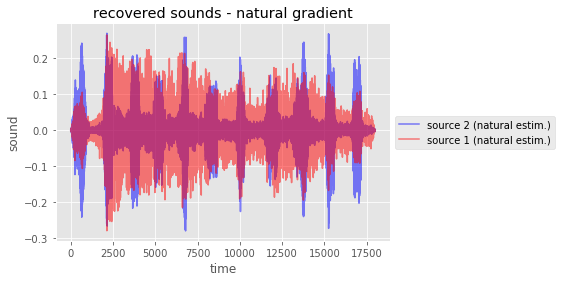

In [189]:
# (iv) Plot & Play the recovered signals using the unpermuted data
plot_and_play_data(s_natural, 'recovered sounds - natural gradient', 'source 1 (natural estim.)', 'source 2 (natural estim.)')

source 1 shuffled (natural estim.):


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAAAAAP//4v/t/wUAJwAXANz/zv92//7+u/5B/gT+Kf/Z/4P/+v4AACUBAwINA6gCUAKRASABAACl/tv9IP/Z/4j/Fv53/fj95P0X/1n+Y//QAMwB2QHiAE3/7ADdA6AEHQMjAUgAvv42ANL/+ABBBZ4GRQeMBzYCHQA7AK//Yft9+bT59fld/b7/0f4/AV8EUQi1CCkGMQMvA3kHjASHAVn//ADaAY4D0gN3A4gBzP8I/pf8pfWc+GgD3ASNAmP/BQAYAKwEvQc5BsMHkgUCA8gB0fcr9z7+VAR6BKoDWwHB+un5Lvl/+D/5zPXc91L5afaI8Zz4rQWcCLAM3gvIBYICEgdVBWsCMQIZA3sFYAEg+TX38vZO9DL1IfTG8w31gv+HAJoBjAbGBpUGVwgRA6r8sAJkBB8Db/9f/cT9/QMSDC8Mwg7gBEH+n/kI66zhsOZl8NL2Qf+aAFL+SQaDEKQSaxXjFTAShg82Bez4UvBR+A4DpwQ9Bz0AO/oM+cH2MPnF/j8AAAKdA2D9/feN/IMF7AfFEbsOwwXKBJoHqwS6A5MHswjQDJQKfgTj/pb+ifzt/Yf3QOwA7GbtQOwt9Hv7Rfg+/mUDSwJhBT8NXxWOFz8UTwGl/An+TwGsAeIESgDO97XqUOX25Y3ojfICAHsGvAbdBXAH1wXQBVwKzgzUBEn/7vqY8Rjv/wG6DFMTHxPRDDIFHQDJ+PXzVfWD8dTsSe9z7e/sXfl8BTAReRecEjkPjRSlED0OoA6RBhICegRmBA38gvtW/S79dwFB/ir4avZG90H5VwNNBE0DUv5s/0P7Wv9vCHYOdRNfDT0AS/5vBTsEQgWpDzQKSf9t+lHyHel162Xy+/ie+Ef5/vqo/2z7+wGjCJMI1AmlCbL/tPJy8rv6pwXIB70DhgC3+5TxjfKp98X4hfSm88TwWe6L8wQAhAeCCygIZASMBykHagSFAy0DXAFhBUwKQgRxA1ULWA6gEWcJL/5z9znwMOhK7EPyIvZS9Zf1Gfgs+pQEOhWJJAUjNxgwEM0JQgTmA+cHawXB+OP1gPKh6qntkPajArcAvQOPCbwK6gaFBcIH/AdYArkGEgQ896v1GgFoDrkTURJ7EHsLLARP/XL9RvxY9WHzGPBj5z3oWvRh/FkGZgRlC2EPpw5YCxgMrgdCBBQAr/9N/AD+sQJ2B7YMzwejApn/qv7M91Dteu3t8SHwgPRb9hDxT/WDBU8UMBbjDloJ7AfBA5D+wgbHCbUBhvu2/+b1SvCM9hb+Rvx8+Cn6I/h89VTzOfZI+Xv7Qv0kBKQCWPvkAs0Nkw/WDSIPggl+AQT8o/ZH9s73EvYj+If3K/EV9mT/tAc7BvsB3AJ3AaoC7AGJ/mH+/QDz/jEBswM/CSwSjhqfFiMRJw3dBz/82PTL7GbrYenh6sTtIfO5+E4ILBLnHpAbGxYmFg0USAqMBPwEqP82+wD9Avnj9Jz6qwbRC1IHEwfzAtICQAFA/lP8Ovy7+fL7AgBS/q/7lwXrCbYIBwtADBMJfwVtAHT42/ZK9y3zWPC28aPwk/FC/Uf/yvuF/48FgQbdBX4HKABO/gn+5fxP+k77cgLMBncKwwhlArkDcAY2AWj54/W/8kbuI/SN9N/yNfes/6kGgAiMCmcLDwvrCTIFSv/1/9EA0f0D/8v+rPxgAnUJtAcaAaj9b/xN+Kv4m/Pv7Jvwxfj3/EwCLQbjC2ANfA+MDZsIVwj5CGQEff6S+Vv2B/f3+1T8MPvv/az/6gEXBbEF8AZpAxsE3gFS/UD7iv+3/Tv90AR9CpAQoRd+GUcT2xNhE2YLvgCv9xbqyuWJ5h3oW+nC7u32aPwDBYwK/go+EY8YAxGkCQIAj/qX8yn1V/QQ9Dz3UgDdAr0C5gPNBp8ELwE+/gfzOu8l8ZXwtvDk+Hn9vQI7ChQNIQl0CSsO9w30Cd0Fjf2m+jz8LPws+3D9R/yx+ar4Cf6J/qH/QgUFBhT+gPtAAcQAywL8BK4HngNcBx0LDwqwDWoR7hDVCuYDmPzR8uzw7/AC8VT2Lf/wALkA2AOtA9UHTRAwEm0NWAIR+/r43PqY/L7+7wP3BiEKZwkpBykIXQbJ/4j70PTZ7rTu2fKW8zf1xflRAAkERQq2DUgKwgbwCMoEPfus83Dz7+8k9b/4afqcANwC6f5EAHwCggJAA/MCy/tk8Evume8d9xr8VwOXBWYG4wi8CsAJZQurEHgQUQsGBZz7mvWq8n/v6O9C91P/hAFjAdkExAizDK4PmBZgEHQGIv+D+IH4o/Z7+v7/agRnBmUNdQzHDMIR1AqD/m/4PfZq9AP4g/iQ+LH6ffwL/HIAUgd9Bo0I1AuKCej+kP5e/DX9hAESBW4CswO8AV39Ff6p/iICSQS+AsP3bPTY8HDwF/o4BdQF9ApzDvEJyQoZDTALywwUDzoI//28+Ar2/vHj8rbxJfb0+Mz5Avsb/gv/0P8DBCcE2QDn/y79Bvy0+fb5Ovvu/uACLAcSC90MKw4bDf0E1vrY8BPuue6+7iP2/Pbr/gIAEAAXBvAK8Qw0Eh0S6wYG/Rb45vPp9hf9/fv6AhYIAAUCAvkC+wIWBBkI6gEI+9vxwvDg7tTx7vb+/fQECQgpCfUM2AsUCkUOEw4KAxf72Pn99vT28vcV9eH48v0WAAgG8ggZCvMM8gkTBPP94fgb+wj76fwK/Af96f78ABQF9AgmDzgT/hPyDDEC2Pnb+Bn44/jK+Cn8AP7X/CL7Af7e/xwDIAjZBBP/CPjj8wT2A/rO+QD9KgfpC/kKFQwFCO4CFwMOAtb43+/m7+/yBvQR9vD78wQnBwEJ3wwQDA8J5ggWChME2/vx+Rz96P7+/iIA/AHkBBoFAAX1BRAEJwb1BgQEGvz08vb1Bvn++vD/KAYRCPYIAgwEDfoIBggaCfwK+wEA99Tx/PP/9Pr3/vz7/wb/DAIFA/cA+gMWB/UE+gID/QP25fgE+/346/jyABMC+wT/CA8J/gQOBv0DCP/39tbv0PH09+v5CfsBAAED/wITBgwJDgcWBh4G+AP7/P/2AvQC+wn/Af8BAgsC+v32/Qj/Bf/7/P79AP0F+wP1CvPx9wj78vj7/P4DBAP8AxAH/QQCA/8C/AQVBgEC//wH//0C+wAFABIGAgMOAvkE+QMBAQb/+/sF/Aj/+Pz4/QkDEwb5BAIMBQoECf0LNA7zDAQK/gT2/e340/HN8e/37vn09/j8Fgb+BA4HDAgZBhEHCwgCBAUD+/z79fb3/v/4AAYDAwoICA8ICQn3BP8DAgQAAAX77vn89fz06/kI+/r8/AMUBxUGCggYBhYG9wQIAgQA+gD9/O75+P32/e/5BPz3AAgCCgL9//38BAD7/PX2BPXP8dnuDPPt+QL7/fz+APv8+P3+BPkEEgb9BAj///vr+QT16fn+//8A/AAOBxgGAQT7Awb//v0FAgAACvvu+PH39vcG+/cA/gP9CzEO9wwwDwQKFAYXBhIHAfz09wb00vD89f/8+wACAwkJDQj7C/sLFQYCAwAA8/f39gf7+/38APsEAAv7CyoQ+Az3DAQKBwIF/wX/7PnX79fv1+8J8//8EgcNCAAL+Az8C/cMAAsJCQkJ/wP89dvu4O3T8AH1B/sCAxUGBQr/CvsLCQkCA/oA+wDr+fv1APUJ8wnz7/gG/wcC+gQSBxEH+QQAAPwA/gP6/QH1BfT89fn2A/wAAAX/BAMVBhAHBQoOCAAABf/7/QX0BfTs+f/8/vwRBwkJCQkACy8PMw4MCAcC+v0B/PP31+8I8/z1B/v8AAwICQkNCBAHAgMAAP78+f0AAAX//PX59gf7AAD6BP0LAQsMCAgJDQgCAwb79PcH+/z10/DT

source 2 shuffled (natural estim.):


<audio controls="controls" >
                    <source src="data:audio/wav;base64,UklGRsSMAABXQVZFZm10IBAAAAABAAEAACAAAABAAAACABAAZGF0YaCMAAAAAAAA///6/wIA+//2/wQA6P8CAPf/5v8IAN3/+/8TAPD/AgA3AOv/XQAdAAcAkwCr/28A3P/G/50Ae/9yABsAKv8dARz/NwCeAFL+SgIU/vgAwQCl/RkDqf3MAEQBD/21A3j9kABAAmf7iwUJ/IwBzgIV+gsIK/njA+cAZ/n0CP71FQcN/qn7UAnW82sLjfpX/8oHLfReDcn1bQVBAtT2jQ1f8hkKy/wV/GYK0PJFDRX3twKdBJH1hw2P8gUJrP4s+rkMdPDPDTT46wCxBrTy3Q7w8k4JIgCV+VEMyPFCDMb50ABVBKL1NAyS80gJZft0/gwGz/cqCm32dghf/HwCeQA4+Y4LePNGDA76Y/+qBJz7gAf98+8LXfRvBL8GW/MIC4b46QQI+i4I//mr/EgSyuhEET7+IPQmEHn36v3cA3wB9vq8BDIFq/BDDeEAbfKnERz2gPpzDsL7j/d2DEP6rfY/FqjzX/p6ETjxgv+kENnvpv5jEbTxWAE9Dq/stgHrED7xff4aEoXrUAIfGxvg1gcNFmbgUxN1CyzggRIgEL3hMxSPCbPeEx3xBzDbQhvrAhnetiW++ergtiUV9n7kqCfw7w3pGyvw56DvJCo+4nz3EyuQ2V78EyuW1sgFeimozTQMoCjUxn4XghyExGgjIxT4ygAloA4azqkm8wkSzgMreAVh0REs3wHN08cuHQBSzmI1M/mwzT0+vesT1gM+rOXI3cA3/uWs4eU48ean49U4SOWY4804qeZG42o4NePo5zo47eI166UvHeMn7+st5uVe7bAnLuzH7ZIpPevA53MsDuw16X0r6Osw6JwszuzO5LwsYO+Q4w4w+O9T4ZoqvPVJ3+cl/fze1x8mpwGo2Q4j2gIT3aMbnguK21kSgRM92WkR+hk21VgPYhtm1jQNghxF1rUJkhzY2uUC8R0b4e3+TiDd4dj5VyNO45n6xiGc4Sr28Sfw54nvKytP5m/siTKg4wbqBzLM4nLoai1S6DPkxjGG7Hnc1jGX8PLcwTJH9DTZfzAL/yTSKyvABSrOEih+CnfKpB/mEEHR7xdcFv3UWA+rG07VXwnPIcfWBQT5J+HZlPvCKsbX1/ifLtvbRfVsKG7jafXRJ47k4O//JeXqRvBsIj7vteunJDHw6OePI2X0GeWxJpT5etsrKyj7F9haKXj+L9hwI6APpdNcFjgYftblCAshN9xc+PcotOJs6SEsTu0b4M8uHfkB1zIo1geF01IbkhK10zITyxyG1usEkh8R3iP56iqy32DxfC+84gfuSywU637k8ipe91HbwSdJB1rOsSPuFSHIzR4dIGTEoRMpKajNc/p8Lxne0+rnNLXp6dlIMtoCAs6uIcsUtsfjHEgmjMQgBB8yptZr8+04NN8V3wY8HPWE0HssMQktytod6yD8xtYF0DSa0Qrx7TgL5KzdDDl2+0jIXCvxGazEshSVL2zEbPtmQV3WA91CRQLxvcS2PmYL47QdLskn3bccC30+hMQ96yZOadsZy49OvP48taM4YCN2q7IcdkFxsTr3MVdVysjPO1fo77Gx40frHDmi1yE0SK+rdva7ZVLBr8qbZQ/vZKheS2YgfprYJEVLhahh8uBgd8o7x2RdbvjSpHhEUyw0mnIYFluEpSDoq3IZyyW4w2WXAvmT80d0O+mTCRMpYb+r6dlbcgfYVqvYYMcPj5PAN4hHuJOFAdxlLbgoy3lsIe56otNUuyn3jVcjxVq2nmzpCXKGx5mx5mtVAjSa0EGlO2WazgcPXmG+2MqzZTHyCaI2ToMsGpTVHnley6Lf46lsB9R2tVBedw70mWQxMUdhpOD2PV09yl3H1131/YSl1TvDNfWlhAi5UYTEf9kpVB32WbH5N8IqurHaCD1L6Mou1dVX8vPLtBM7PSQ/sfQNRUFtx/3iPUtz86m+gTXvIW64GQ7vPvjKSt5AUTny/7ruMfwfu7R1DetKUsFS3mhRYO+TwUo4XB7jtOYMG0isxHrbiFGo7pq+qzjvHma1aQ06RejKsdyaR4H5xr1DLwcm9befAk9OCs432ERIJfj1wZcu+Sf2ui/9uUSx3MvRvj49BpK+ECVxNYK+ae8DSFzh6s/xOpwI+MBoGdQtuM3e7Ho4GvHV01wrkhIRy3ULBC5H2V/ntjRJ9wrQlyRLFgLOYQYLK7bkJeO0LKoDs9FPGRMh4tL19hg1Luxp2xooCwlO1VEQjyMH4inuQihf/ancuxbbFSXZh/sxKZ/t+99hJr0HPtVpEG4dpuCk8/gkK/kh3pAZoRMx3q8AxiEQ7Z/m5R62C8vbrAp0HtTiePDWIi38Id4KFsIT9eKt/RUgAvH55zQdhwnN4cUGUhtl6grzjB6I+tjnsRGhEaTph/lzFaj5kO4YEAwLZ+cn/pEWfPW58WkPIgM78d0ENw1v+Az1uwp/Bor1kf7dC0/8QPRZCC0FJfab/gAH0gD295r+TQv0/pb2AQgEBpr05v6tDDf9wvM0BRII0fn++20GEAIL+GD/JQtA/ljzbwdCBon21v78BYP/CvzN/+sD4AEG/I0B+wjn/cb30AZJA+P58wAZAg7+sf4jAUwC5wGA+kX93QZ0/5L8SQMw/i/+6gHd/oYBIgG0+MwAvgiN/Ob7pAdJ/uL7WwRy/n8AIwDP+icDvwHE+i0DhQV5+0oBeQRJ+2cBJwMA+3T/vwTf/bT9YQbv/yT6IQVKAjL6pwauASL2KQSfBP32kAKJCLr2eP4OCW/5If75BxT6tfu9B5j85/qZB+D9L/qcBmv/Nfq7BPYBXPoQAvAEQftz/ssFfP3r+5wFO//X+ggExQH9+uYBCQaJ+6z+Qggp/En7Bglx/rf4xQaVAQf4dgJkBZP4yv7GB/j7CfyiBtv+QPpvBCYBi/rZAcQD1/tH/3EExP5t/akDuAEh/FMB2gK2/S/+oAHa/yL+6P9FAcb/y/5p/+kAAQEN/zsBGQKJ/hL+LAJVAJn82gA7Akf99/98Aqz+Ff/OAWsASf8CALD/Ef+m/+j/EP+1/2MA+QCVAE//6ADm/zD+mAF9AOj9NQDrAP7+wABvARb/vv+4AEn/4P9kAN3+a/8JABH/Tf9VAFv/GP99ACAAtf+2AIQAef8xAMcAxf8xAFYBhP9i/3cBBwC7/uAAGABB/loATAHD/q3/fQEY/0n/RgEhAKH+lQBzAOr+BQAqAf3/9v98ATcAR/+4AF0AYf7A/9IAB/+N/y0BAABH/88AcwA3/yAAjAA//2n/fQDi/xD/fQC3AFD/nAA7Aav/LwDXANb/Jv8AAAkAIP+X/6EAtv9b/8kAhACK/0oAvgCb/+b/1wDG/wb/UwAZAAf/OgC4ANX+Y/8CAa3/SP/IAAAA7f5kAE0Arf5c//P/6P5S/9IAAABZ/2QAUwBH/0EA4AB5/0n/jwC2/8b+TACWAA7/1v/oAJv/iv/PAJT/3f6NADIA9/76/24AQv/Y/+kAIAD9/6QAaADl/1AAfADN/wYAEQCN/zv/n/+w/4T/BwAxAP7/QQCSAGAAMQAxAOf/v//R/6b/pf/W/97/PwBgAFAANgBoADcA+P/5/+D/nf9l/2X/Zf9//53/BgAnAFgANgAuAGgAPwAvAC8A7/+w/3b/Vf9t/4//v/8xADEAHgBxAGAAFgAYADoABwDP/+L/qP9//5j/4P/G//j/KAAGACAAQQDO/73/IADX/3b/h/+X/4X/lf8AAOD/zv8xAFIAHgD2/xkA4P+M/4f/oP+E/4T/6P8gAP7/LwBYAC8AJwBaAPj/vv/5/9n/Zf+x/7D/pv/v/1oAFgAOAFIAGADO/8//8P/O/+D/yf+F/43/AAAPAP3/DQBaAEgADgAYAPH/jf+//8n/bf9t

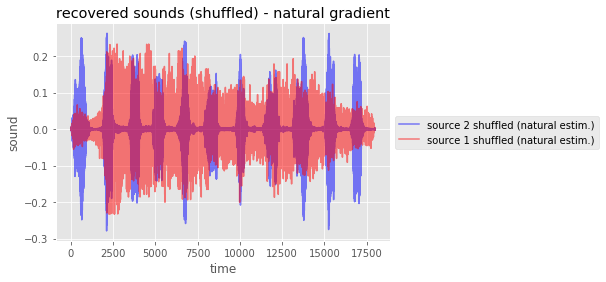

In [190]:
# (iv) Plot & Play the recovered signals using the unpermuted data
plot_and_play_data(s_natural_shuffled, 'recovered sounds (shuffled) - natural gradient', 'source 1 shuffled (natural estim.)', 'source 2 shuffled (natural estim.)')

**(b)** Calculate the correlations (as above) between the true sources and the estimations.

Correlation
[[ 0.99047052  0.83171971]
 [-0.1368792   0.55634368]]


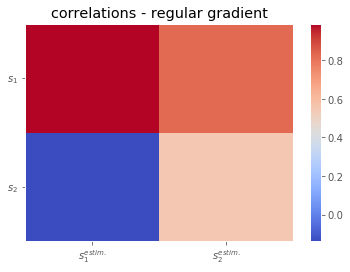

In [191]:
corr = compute_correlation(s_regular, s)
plot_correlation(corr, 'correlations - regular gradient', '$s_1^{estim.}$', '$s_2^{estim.}$')

Correlation
[[ 0.29363785  0.96259524]
 [ 0.9563442  -0.26993508]]


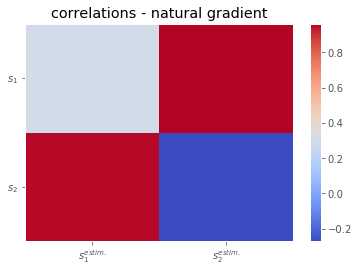

In [192]:
corr = compute_correlation(s_natural, s)
plot_correlation(corr, 'correlations - natural gradient', '$s_1^{estim.}$', '$s_2^{estim.}$')

**(c)** For every 1000th update, plot $||∆W||^2_F := N i=1,j=1(∆w_{i,j})^2$ to compare the convergence
speed for the two gradient methods. Whiten your data before applying ICA and compare the learning speeds again. Describe the differences between the two variants of the learning
algorithm.

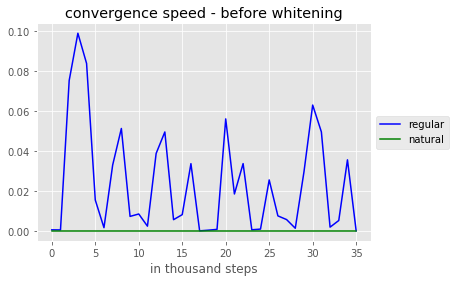

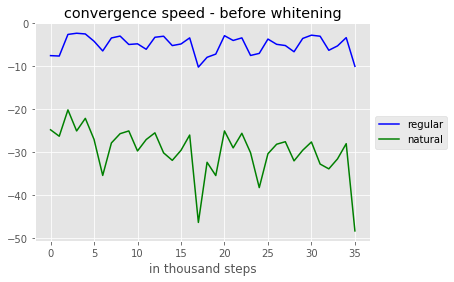

In [193]:
def plot_convergence_speed(vals_regular, vals_natural, title):
        x_axis = sp.arange(sp.asarray(vals_regular).shape[0])

        plt.figure()
        plt.plot(x_axis, vals_regular, 'b-', label='regular')
        plt.plot(x_axis, vals_natural, 'g-', label='natural')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        plt.grid(True)
        plt.xlabel('in thousand steps')
        plt.ylabel('')
        plt.title(title)
        plt.show()

def plot_convergence_speed_log(vals_regular, vals_natural, title):
    x_axis = sp.arange(sp.asarray(vals_regular).shape[0])
    
    plt.figure()
    plt.plot(x_axis, sp.log(vals_regular), 'b-', label='regular')
    plt.plot(x_axis, sp.log(vals_natural), 'g-', label='natural')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.grid(True)
    plt.xlabel('in thousand steps')
    plt.ylabel('')
    plt.title(title)
    plt.show()

# before whitening
plot_convergence_speed(vals_regular, vals_natural, 'convergence speed - before whitening')
plot_convergence_speed_log(vals_regular, vals_natural, 'convergence speed - before whitening')

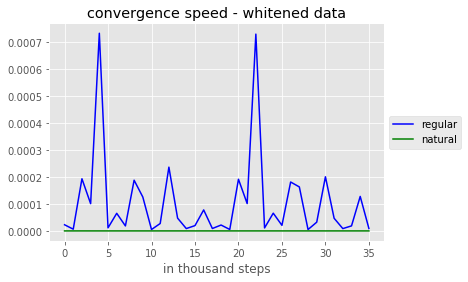

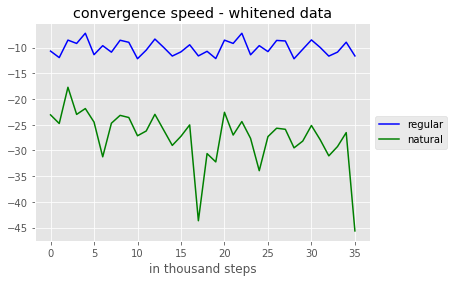

In [194]:
def whitening(x):
    mean = sp.mean(x, axis=1).reshape((2,1))
    x = x - mean
    
    # determine the eigenvalues and eigenvectors (PCs)
    C = sp.cov(x, bias=True)
    eigenValue, eigenVector = sp.linalg.eig(C)
    
    # order the eigenvalues and eigenvectors
    idx = eigenValue.argsort()[::-1]   
    eigenValue = eigenValue[idx]
    eigenVector = eigenVector[:,idx]
    
    # create E
    E = eigenVector[:, 0].reshape((eigenVector.shape[0], 1))
    for i in range(eigenVector.shape[1] - 1):
        E = sp.hstack((E, eigenVector[:, i+1].reshape((eigenVector.shape[0], 1))))
    
    # create Λ
    temp = sp.power(eigenValue, -1/2) # ** (-1/2)
    llambda = sp.eye(eigenValue.shape[0]) * temp.reshape((eigenValue.shape[0], 1))
    
    # compute Z
    Z = sp.dot(x.T, E)
    Z = sp.dot(Z, llambda)
    Z = Z.T
    return Z

# compute whitened data
x_whitened = whitening(sp.copy(x))
x_whitened = x_whitened.astype(float)

# calculate ICA
W_regular2, vals_regular2 = ICA(sp.copy(W), x_whitened)
s_regular2 = unmix_sources(W_regular, x_whitened)
W_natural2, vals_natural2 = ICA(sp.copy(W), x_whitened, method='natural')
s_natural2 = unmix_sources(W_natural, x_whitened)

# plot data
plot_convergence_speed(vals_regular2, vals_natural2, 'convergence speed - whitened data')
plot_convergence_speed_log(vals_regular2, vals_natural2, 'convergence speed - whitened data')

**Differences between the two variants of the learning algorithm:**
* The natural gradients are normalized whereas the regular gradients has large variations in its step sizes. 
* While the step sizes diminish towards the end of the training epochs they still vary wildly compared to natural gradients, potentially missing the global minimum.
* Whitening accelerates convergence for the regular gradient, whereas it decreases the convergence for the natural gradient.
* Whitening takes away the information of the error surface/KL-Divergence on which the natural gradients depend upon for its faster convergence speed relative to the regular gradients.

**(d)** Plot the density of the mixed, unmixed, and true signals & interpret your results.

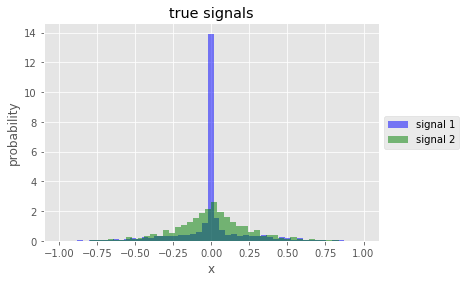

In [195]:
def plot_histogram(data1, data2, title, label1, label2):
    plt.figure()
    plt.hist(data1/np.amax(abs(data1)), 50, normed=1, facecolor='blue', alpha=0.5, label=label1)
    plt.hist(data2/np.amax(abs(data2)), 50, normed=1, facecolor='green', alpha=0.5, label=label2)
    plt.grid(True)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('probability')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.show()

plot_histogram(s[0, :], s[1, :], 'true signals', 'signal 1', 'signal 2')

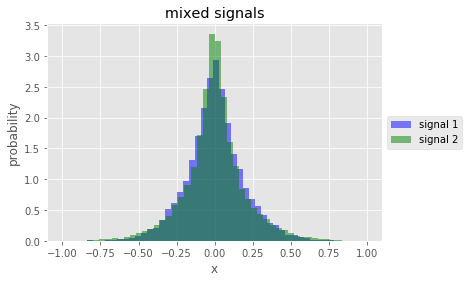

In [196]:
plot_histogram(x[0, :], x[1, :], 'mixed signals', 'signal 1', 'signal 2')

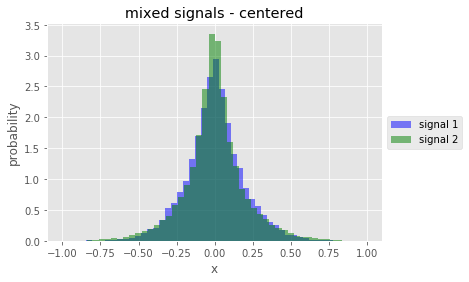

In [197]:
plot_histogram(x_centered[0, :], x_centered[1, :], 'mixed signals - centered', 'signal 1', 'signal 2')

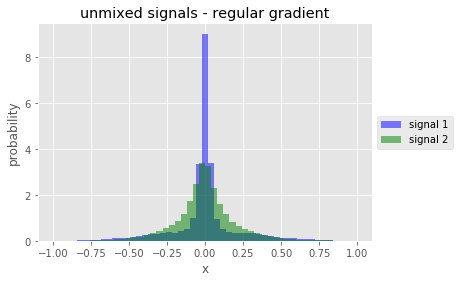

In [198]:
plot_histogram(s_regular[0, :], s_regular[1, :], 'unmixed signals - regular gradient', 'signal 1', 'signal 2')

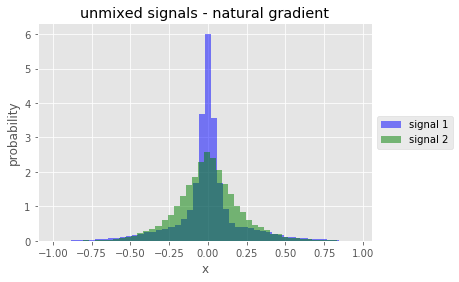

In [199]:
plot_histogram(s_natural[1, :], s_natural[0, :], 'unmixed signals - natural gradient', 'signal 1', 'signal 2')

**Interpretation:**
* It can be seen nicely how the regular gradients achieve densities which are closer to the original, unmixed signals.
* Applying regular gradients results in a very 'peaky' density.

In [199]:
# END